<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/examples/blob/main/example-analysis/congestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides access to congestion data we have available for analysis. Please contact [scope lab](https://scope-lab.org) for details.

# Installation of Required Packages

In [ ]:
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!wget -q https://downloads.apache.org/spark//spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz > /dev/null
os.environ["SPARK_HOME"] = "spark-2.4.5-bin-hadoop2.7"
!pip install -q findspark
!pip install jsonlines
import findspark
findspark.init()

In [ ]:
import time
from copy import deepcopy
import json
import pymongo
import geopandas as gpd
import os
import folium
from dateutil import tz
import datetime
import pandas as pd
import seaborn as sns
from shapely.ops import cascaded_union
from shapely.geometry import *
from IPython.display import HTML
from IPython.display import display
from IPython.display import IFrame
from getpass import getpass
import pytz
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
from google.colab import files

%matplotlib inline


In [ ]:
#The entry point to using Spark SQL is an object called SparkSession. It initiates a Spark Application which all the code for that Session will run on
# to larn more see https://blog.knoldus.com/spark-why-should-we-use-sparksession/
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

# DB Connection 

In [ ]:
USER = getpass('Enter User Name here: ')
PASS = getpass('Enter Password here: ')
AUTH_DB  = getpass('Enter AUTH_DB here: ')
HOST   = getpass('Enter HOST here: ')
PORT    = getpass('Enter PORT here: ')

In [13]:
mongo_url = "mongodb://{}:{}@{}:{}/?authSource={}".format(USER,
                                                         PASS,
                                                         HOST,
                                                         PORT,
                                                         AUTH_DB)

client = pymongo.MongoClient(mongo_url)
db = client['data-class']
print("collection names: {}".format(db.list_collection_names()))

collection names: ['here.chattanooga', 'mds-availability-bird-v3', 'here.nashville.shapes.elevation', 'here.chattanooga.shapes', 'darksky.chattanooga', 'here.nashville.shapes', 'geo_incidents', 'etrims.accidents', 'darksky.nashville', 'rt.gtfs.nashville.vehicle.positions', 'here.nashville', 'mds-trips-bird-v3']


# Data Sample

Look at [The documentation from here](http://documentation.developer.here.com/pdf/traffic_hlp/6.0.68.0/Traffic%20API%20v6.0.68.0%20Developer%27s%20Guide.pdf), page 20.

In [ ]:
#check the schema of the weather data.
data_sample = db['here.nashville'].find_one()
data_sample

{'CN': 0.85,
 'FF': 52.82,
 'JF': 0.0,
 'SP': 55.3,
 'SU': 59.69,
 '_id': ObjectId('5e47772fa57a25d93dadb8ae'),
 'description': 'I-65/Exit 211',
 'lane_type': 'TR',
 'length': 0.22556,
 'queue_direction': '+',
 'time': 1576817154,
 'time_ms': 1576817154000,
 'time_s': 1576817154,
 'timezone': 'America/Chicago',
 'tmc_id': '4208+0.22556',
 'tmc_pc_queue': '4208+',
 'tmc_point_code': 4208}

# Traffic Data Range

In [142]:
#how much data do we have the collection.
epoch_time_field = "time"
time_zone = tz.gettz('America/Chicago')
collection = 'here.nashville'

central_time = pytz.timezone("US/Central")

# earliest time
timestamp_utc = db[collection].find({epoch_time_field: {"$exists": True}}).sort([(epoch_time_field, 1)]).limit(1).next()[epoch_time_field]
time_object = datetime.datetime.fromtimestamp(timestamp_utc).replace(tzinfo=datetime.timezone.utc).astimezone(central_time)
print("earliest time: {}".format(time_object.strftime("%B %d, %Y")))

# latest time
timestamp_utc = db[collection].find({epoch_time_field: {"$exists": True}}).sort([(epoch_time_field, -1)]).limit(1).next()[epoch_time_field]
time_object = datetime.datetime.fromtimestamp(timestamp_utc).replace(tzinfo=datetime.timezone.utc).astimezone(central_time)
print("latest time: {}".format(time_object.strftime("%B %d, %Y")))

earliest time: August 20, 2019
latest time: April 10, 2020


# Working with traffic shapes

Traffic data is provided for every road that is included in the traffic message channel. But this does not include all roads in the city. See below.



In [ ]:
#Each TMC id represents a list of geo-coordinates representing a road segment. We store these static objects in the collection "here.nashville.shapes".
example_shape = db['here.nashville.shapes'].find_one()
example_shape

## Plotting All the TMC Ids

In [ ]:
def plot_tmc_ids(response):
  static_shape_data = [x for x in response]
  shp_list = [asShape(MultiLineString(x['geom']['coordinates'])) for x in static_shape_data]
  shp = cascaded_union(shp_list)
  center = shp.centroid
  m = folium.Map(location=[center.y, center.x], zoom_start=13)
  bounds = shp.bounds
  m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
  style_function = lambda x: {"color": 'blue'}
  folium.GeoJson(mapping(shp), style_function=style_function, name='geom').add_to(m)
  folium.LayerControl().add_to(m)
  return m


In [82]:
#lets plot all of them on map. Only works in safari or firefox
response = db['here.nashville.shapes'].find_one()
response

{'_id': ObjectId('5e4af098370ffd62cfb3ba21'),
 'free_flow_speed': 52.82,
 'geom': {'coordinates': [[[-86.76045, 36.1548],
    [-86.76076, 36.1548],
    [-86.761, 36.1548],
    [-86.76128, 36.15477],
    [-86.76153, 36.15475]],
   [[-86.76153, 36.15475],
    [-86.76185, 36.15468],
    [-86.76208, 36.15463],
    [-86.76232, 36.15454],
    [-86.76253, 36.15445]],
   [[-86.76253, 36.15445],
    [-86.76279, 36.15431],
    [-86.76345, 36.15395],
    [-86.76412, 36.15364]]],
  'type': 'MultiLineString'},
 'tmc_id': '4208+0.22556',
 'tmc_pc_queue': '4208+'}

## Downtown Nashville

### Selecting TMC id in a given geojson bounding box

Get the geojson bounding box from http://geojson.io/#map=15/36.1540/-86.8083


In [139]:
# geojson_coordinate_list= [
#           [
#             [
#               -86.79559707641602,
#               36.17120905454304
#             ],
#             [
#               -86.79362297058105,
#               36.1477864065951
#             ],
#             [
#               -86.7579174041748,
#               36.15707314562296
#             ],
#             [
#               -86.76924705505371,
#               36.177167546381085
#             ],
#             [
#               -86.79559707641602,
#               36.17120905454304
#             ]
#           ]
#         ]

geojson_coordinate_list=[
          [
            [
              -86.79739952087402,
              36.170931904360835
            ],
            [
              -86.78109169006348,
              36.14951909060777
            ],
            [
              -86.7619514465332,
              36.15728104510431
            ],
            [
              -86.7740535736084,
              36.17585117438683
            ],
            [
              -86.79739952087402,
              36.170931904360835
            ]
          ]
        ]
query={
     "geom": {
       "$geoWithin": {
          "$geometry": {
             "type" : "Polygon" ,
             "coordinates": geojson_coordinate_list
          }
       }
     }
   }
selected_tmcs=db['here.nashville.shapes'].find(query)
selected_tmc_objects=[x for x in selected_tmcs]
selected_tmc_ids=[x['tmc_id'] for x in selected_tmc_objects]
len(selected_tmc_ids)
 

115

In [140]:
plot_tmc_ids(selected_tmc_objects)

### Finding Traffic  Statistics for these TMCs in a given Date Range

In [ ]:
#this function aggregates and averages various metrics per hour of the day for the tmcs in selected area
def get_hourly_averages(start_time, end_time,city='nashville'):  
  pipeline = [{"$match": {"time": {"$gte": start_time.timestamp(), "$lte": end_time.timestamp()}}},
              {"$match": {"tmc_id": {"$in": selected_tmc_ids}}},
              {"$group": {"_id":  
                              {
                                "tmc_id":"$tmc_id",
                                "hour":{"$dateToString": {"format": "%Y-%m-%dT%H", "date": {"$toDate": {"$multiply" : ["$time", 1000]}}}},                                
                              },
                    "tmc_id":{"$first":"$tmc_id"},
                    "hour":{"$first":{"$dateToString": {"format": "%H", "date": {"$toDate": {"$multiply" : ["$time", 1000]}}} }},
                    "description":{"$first":"$description"},
                    "day":{"$first":{"$dateToString": {"format": "%w", "date": {"$toDate": {"$multiply" : ["$time", 1000]}}} }},
                    "sigma_SU": {"$stdDevPop": "$SU"}, 
                    "mu_SU": {"$avg": "$SU"},  
                    "mu_jf": {"$avg": {"$divide" : [ {"$max":[{ "$subtract": ["$FF","$SU"]},0]}, "$FF"]}},    
                    "JF": {"$avg": "$JF"},
                    "CN": {"$avg": "$CN"},
                    "count":{"$sum":1}
                    }
              }            ]
  if city=='chattanooga':
    result = db['here.chattanooga'].aggregate(pipeline,allowDiskUse=True)  
  else:
    result = db['here.nashville'].aggregate(pipeline,allowDiskUse=True)
  df=pd.DataFrame(result)  
  spDF = spark.createDataFrame(df)
  spdf=spDF.drop('_id')
  return df,spdf






In [ ]:
#produces a box plot from data retrieved by query above
def plot_hour_boxplot(df,key,savefilename="",title=""):
  boxplot = df.boxplot(column=[key],by=['tmc_id'])
  plt.xticks(
      rotation=45,
      horizontalalignment='right',
      fontweight='light',
      fontsize='small',
  )
  fig = plt.gcf()
  fig.set_size_inches(25.5, 10.5)
  if len(title)==0:
    plt.title("boxplot of "+key)
  else:
    plt.title(title)
  plt.suptitle("")
  if len(savefilename)==0:
    savefilename=key+".png"
  fig.savefig(savefilename)  
  files.download(savefilename)
  return boxplot

In [ ]:
#produces a heatmaps from data retrieved by query above
def plot_spdf_hour_heatmap(spdf,key,suffix=""):
    rspdf=spdf.filter((spdf.day!=1)& (spdf.day!=7) ).groupBy('hour','description').agg(f.avg(key).alias(key))
    heatmap1_data = rspdf.select("*").toPandas().pivot_table(index='hour', columns='description',values=key)
    if key is 'CN':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="RdYlGn",vmin=0, vmax=1)
    if key is 'JF':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="YlOrRd",vmin=0, vmax=5)
    if key is 'mu_jf':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="YlOrRd",vmin=0, vmax=1)
      
    if key is 'mu_SU':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="RdYlGn",vmin=0, vmax=40)    
    fig = plt.gcf()    
    fig.set_size_inches(40.5, 10.5)
    plt.title("Heatmap of "+key+" "+suffix)
    plt.suptitle("")
    savefilename="Heatmap-"+key+suffix+".png"
    fig.savefig(savefilename)      
    #files.download(savefilename)
    return heatmap


In [ ]:
#produces a heatmaps from data retrieved by query above
def plot_spdf_day_heatmap(spdf,key,suffix=""):
    rspdf=spdf.groupBy('day','description').agg(f.avg(key).alias(key))
    heatmap1_data = rspdf.select("*").toPandas().pivot_table(index='day', columns='description',values=key)
    
    if key is 'CN':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="RdYlGn",vmin=0, vmax=1)
    if key is 'JF':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="YlOrRd",vmin=0, vmax=5)
    if key is 'mu_jf':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="YlOrRd",vmin=0, vmax=1)
      
    if key is 'mu_SU':
      heatmap=sns.heatmap(heatmap1_data,xticklabels=True, yticklabels=True, cmap="RdYlGn",vmin=0, vmax=40)    
    fig = plt.gcf()    
    fig.set_size_inches(40.5, 10.5)
    plt.title("Heatmap of "+key+" "+suffix)
    plt.suptitle("")
    savefilename="Heatmap-"+key+suffix+".png"
    fig.savefig(savefilename)  
    #files.download(savefilename)
    return heatmap

#### Month of April

In [ ]:
start_time1 = datetime.datetime(year=2020, month=4, day=1, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
end_time1 = datetime.datetime(year=2020, month=4, day=10, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
#let us say we want to aggregate averages by per hour
df,spdf=get_hourly_averages(start_time1,end_time1)


In [147]:
spdf.printSchema()

root
 |-- tmc_id: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- description: string (nullable = true)
 |-- day: string (nullable = true)
 |-- sigma_SU: double (nullable = true)
 |-- mu_SU: double (nullable = true)
 |-- mu_jf: double (nullable = true)
 |-- JF: double (nullable = true)
 |-- CN: double (nullable = true)
 |-- count: long (nullable = true)



##### Hourly Averages

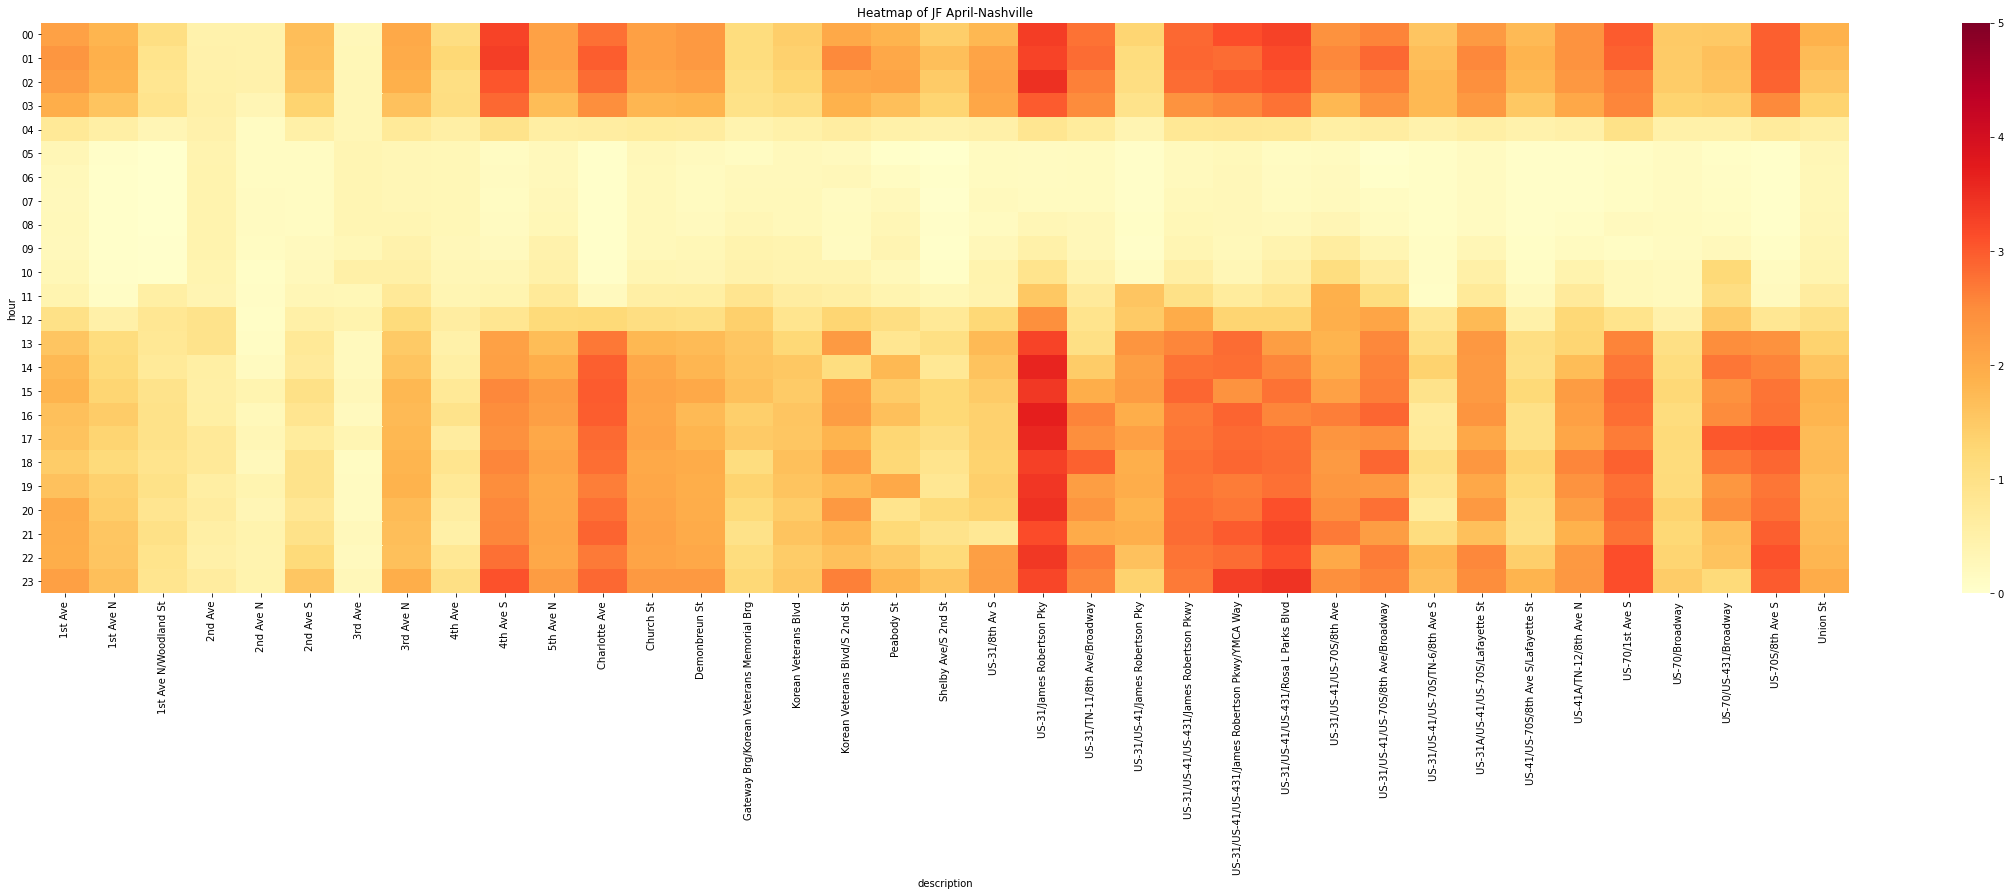

In [180]:
a=plot_spdf_hour_heatmap(spdf,'JF',"April-Nashville")


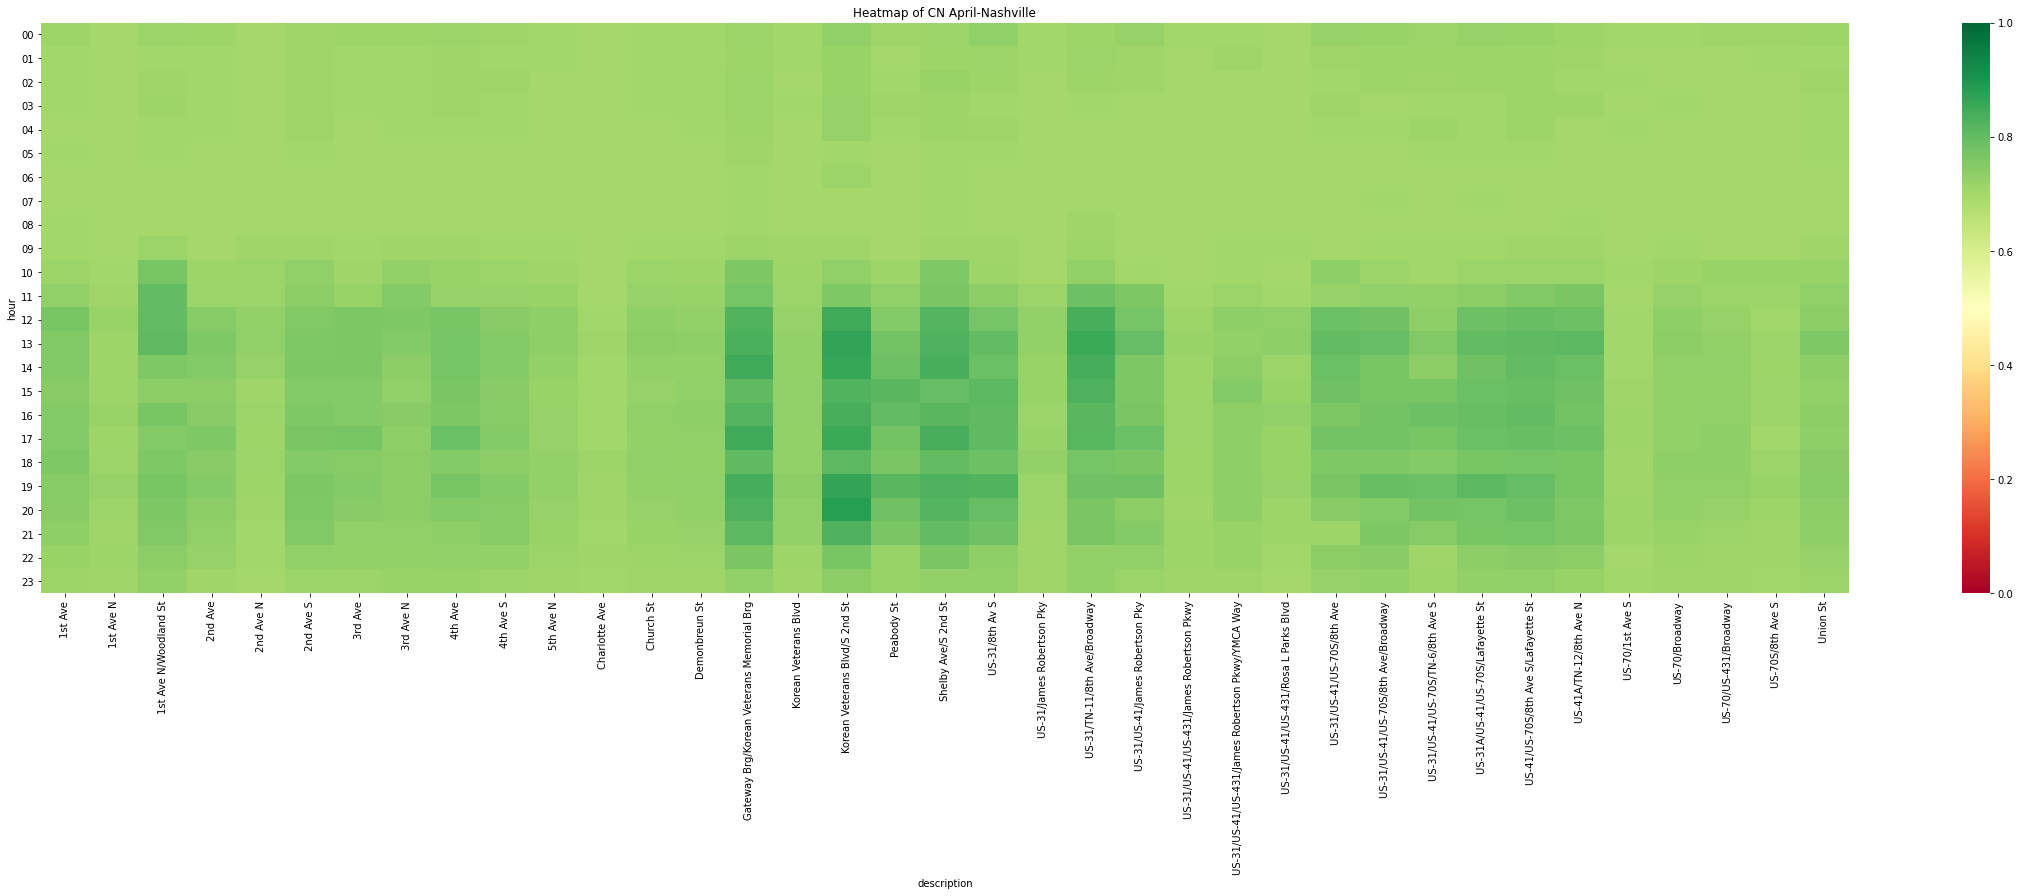

In [181]:
plot_spdf_hour_heatmap(spdf,'CN',"April-Nashville")

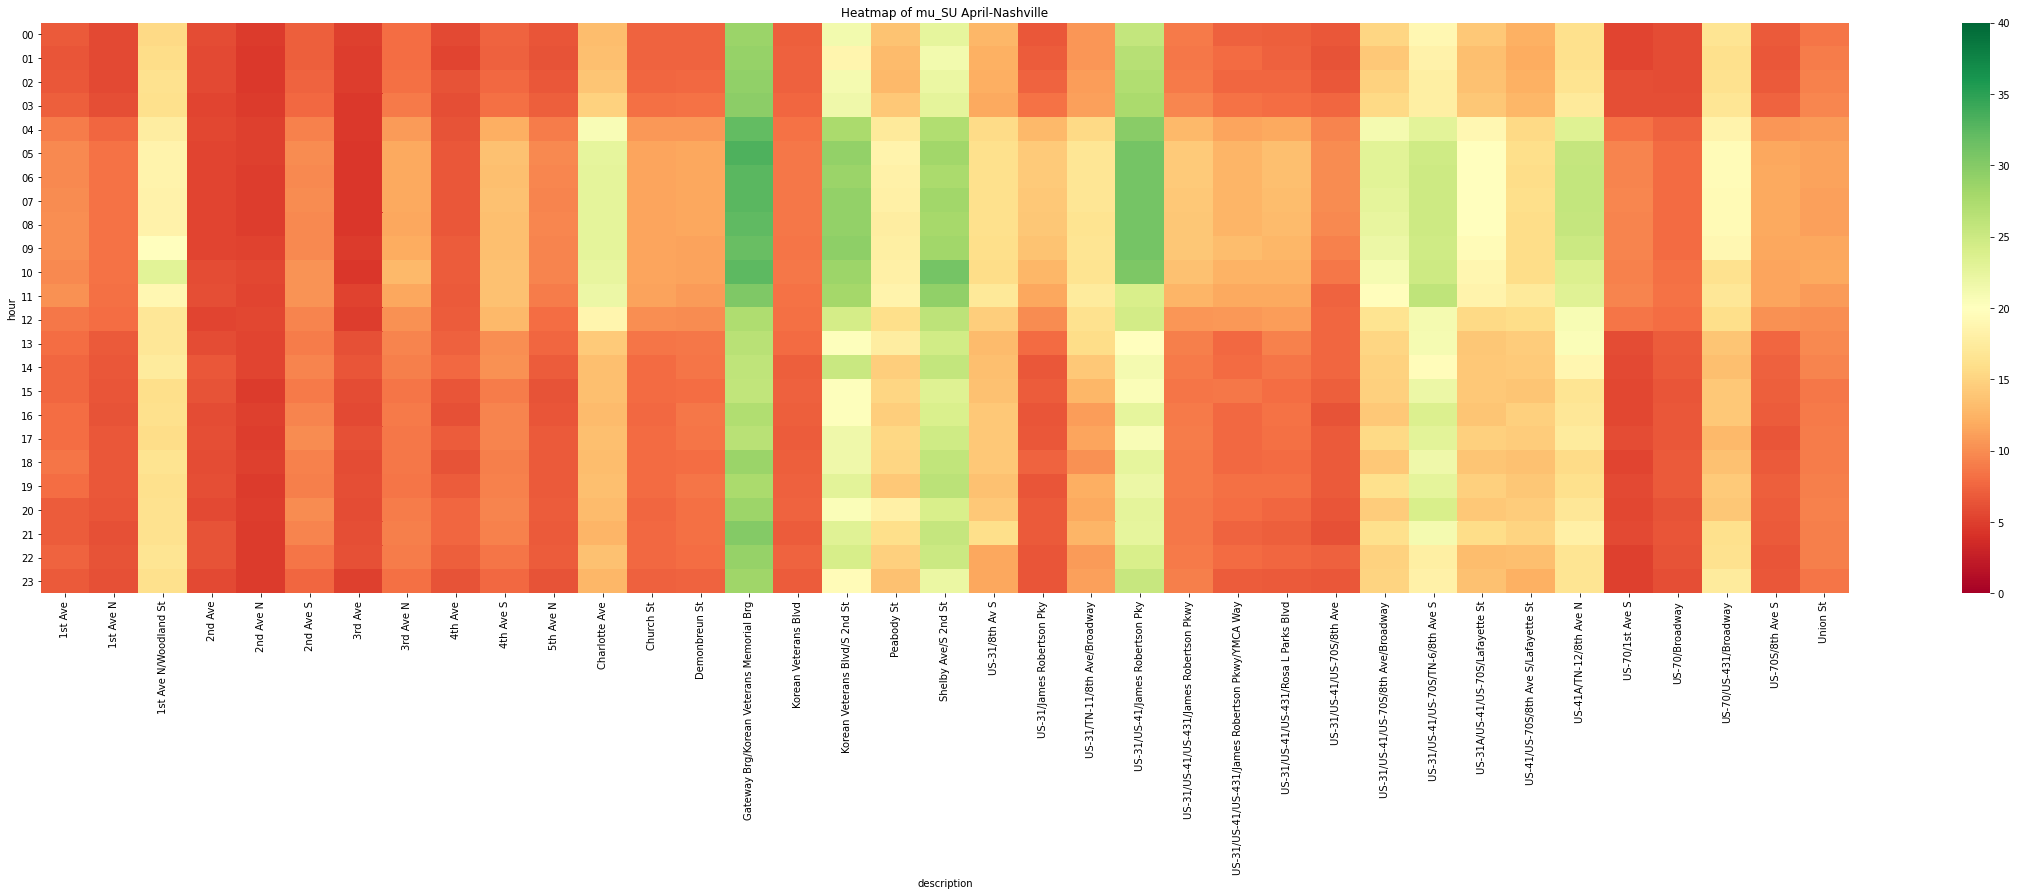

In [182]:
plot_spdf_hour_heatmap(spdf,'mu_SU',"April-Nashville")

##### Daily Averages

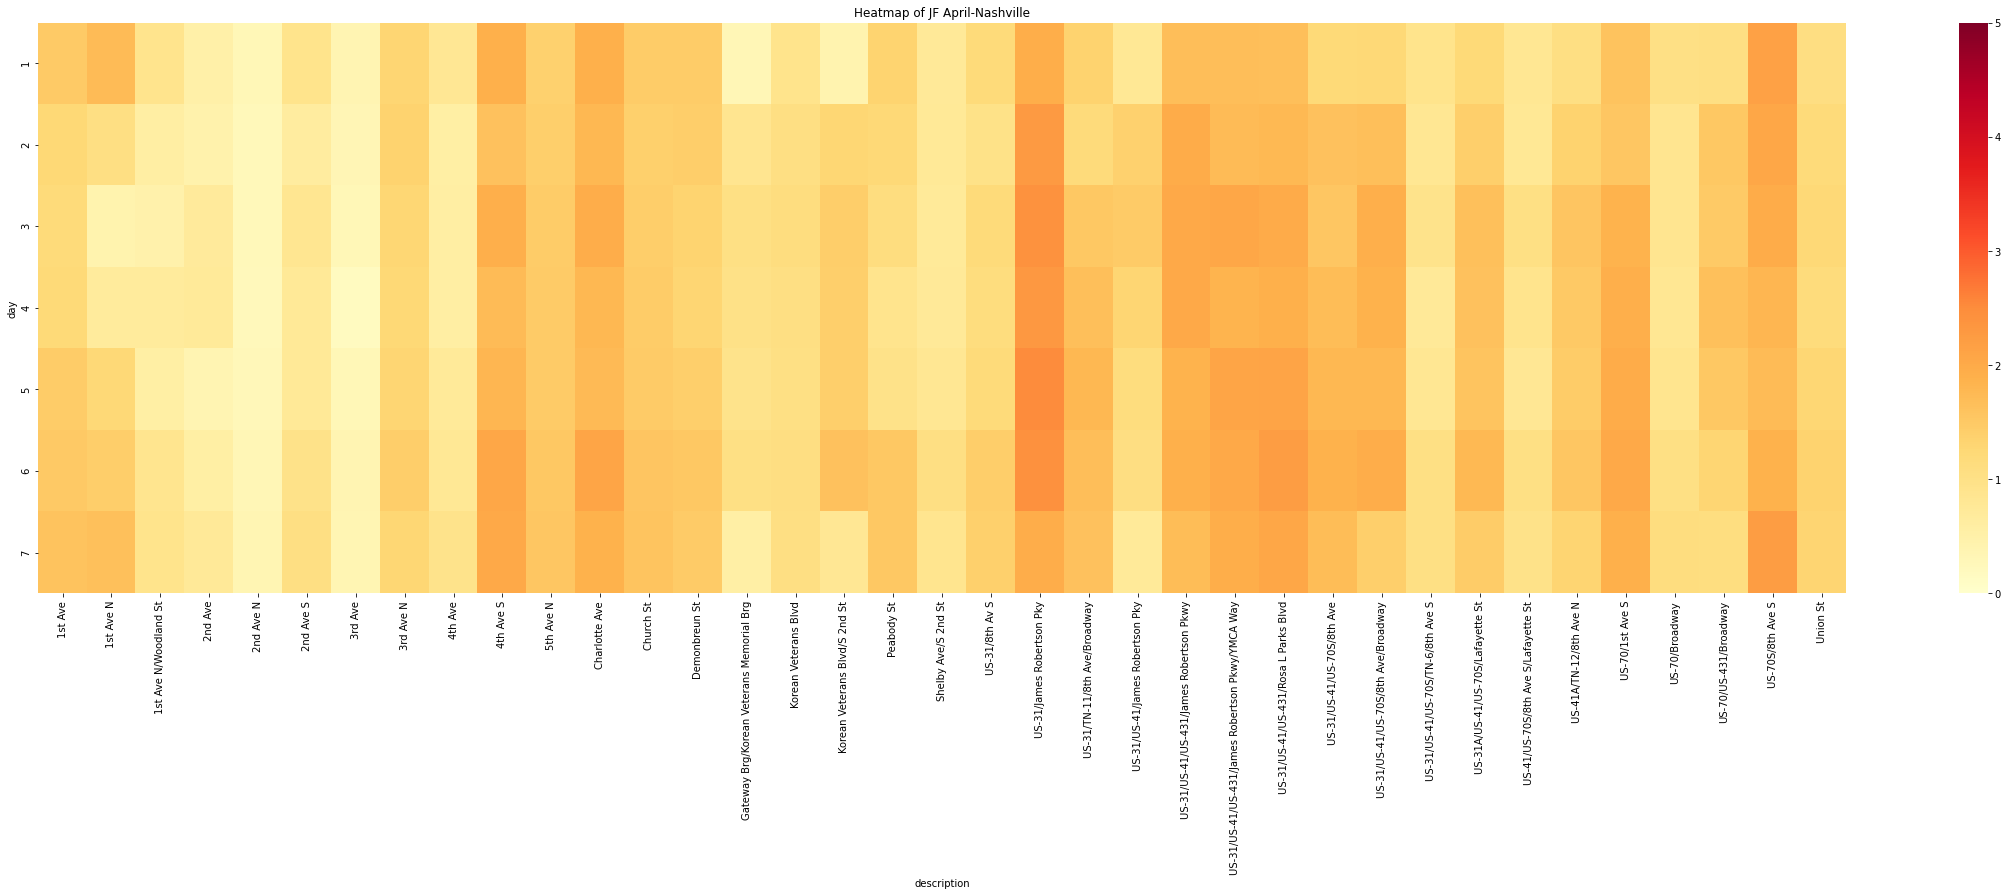

In [183]:
plot_spdf_day_heatmap(spdf,'JF',"April-Nashville")


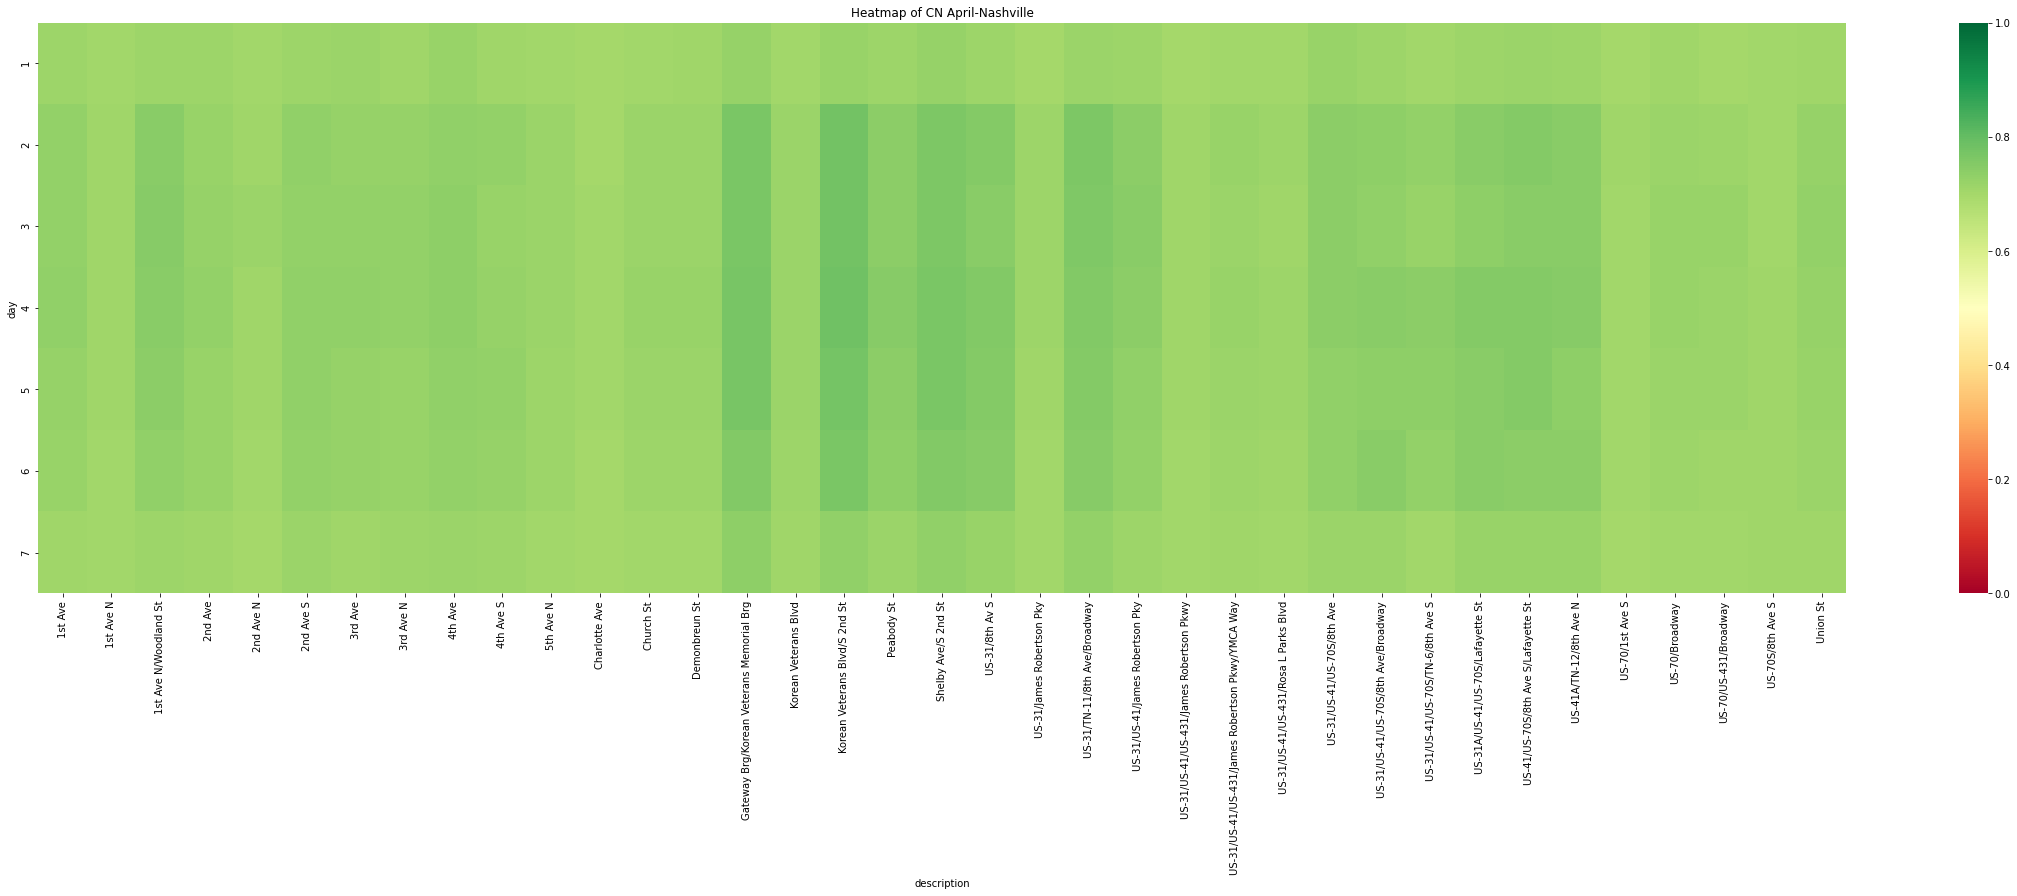

In [184]:
plot_spdf_day_heatmap(spdf,'CN',"April-Nashville")


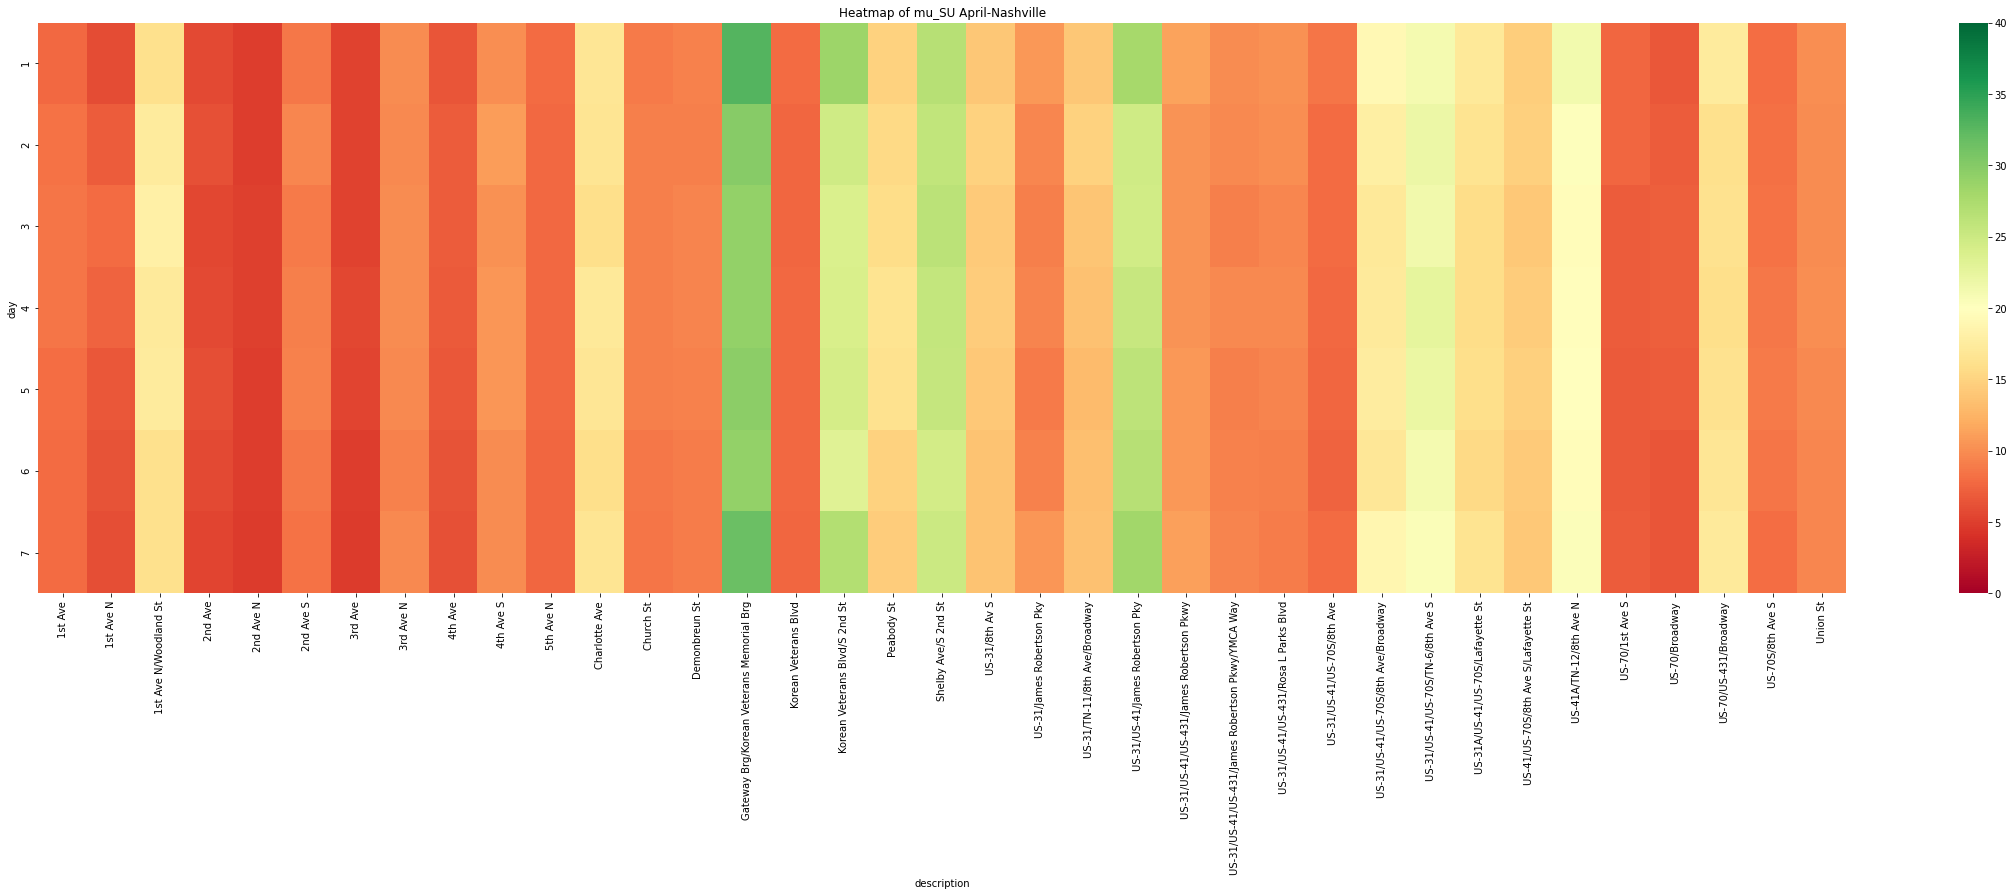

In [185]:
plot_spdf_day_heatmap(spdf,'mu_SU',"April-Nashville")

#### Month of September 2019

In [ ]:
start_time = datetime.datetime(year=2019, month=9, day=1, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
end_time = datetime.datetime(year=2019, month=9, day=30, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
result,spdf=get_hourly_averages(start_time,end_time)


##### Hourly Averages

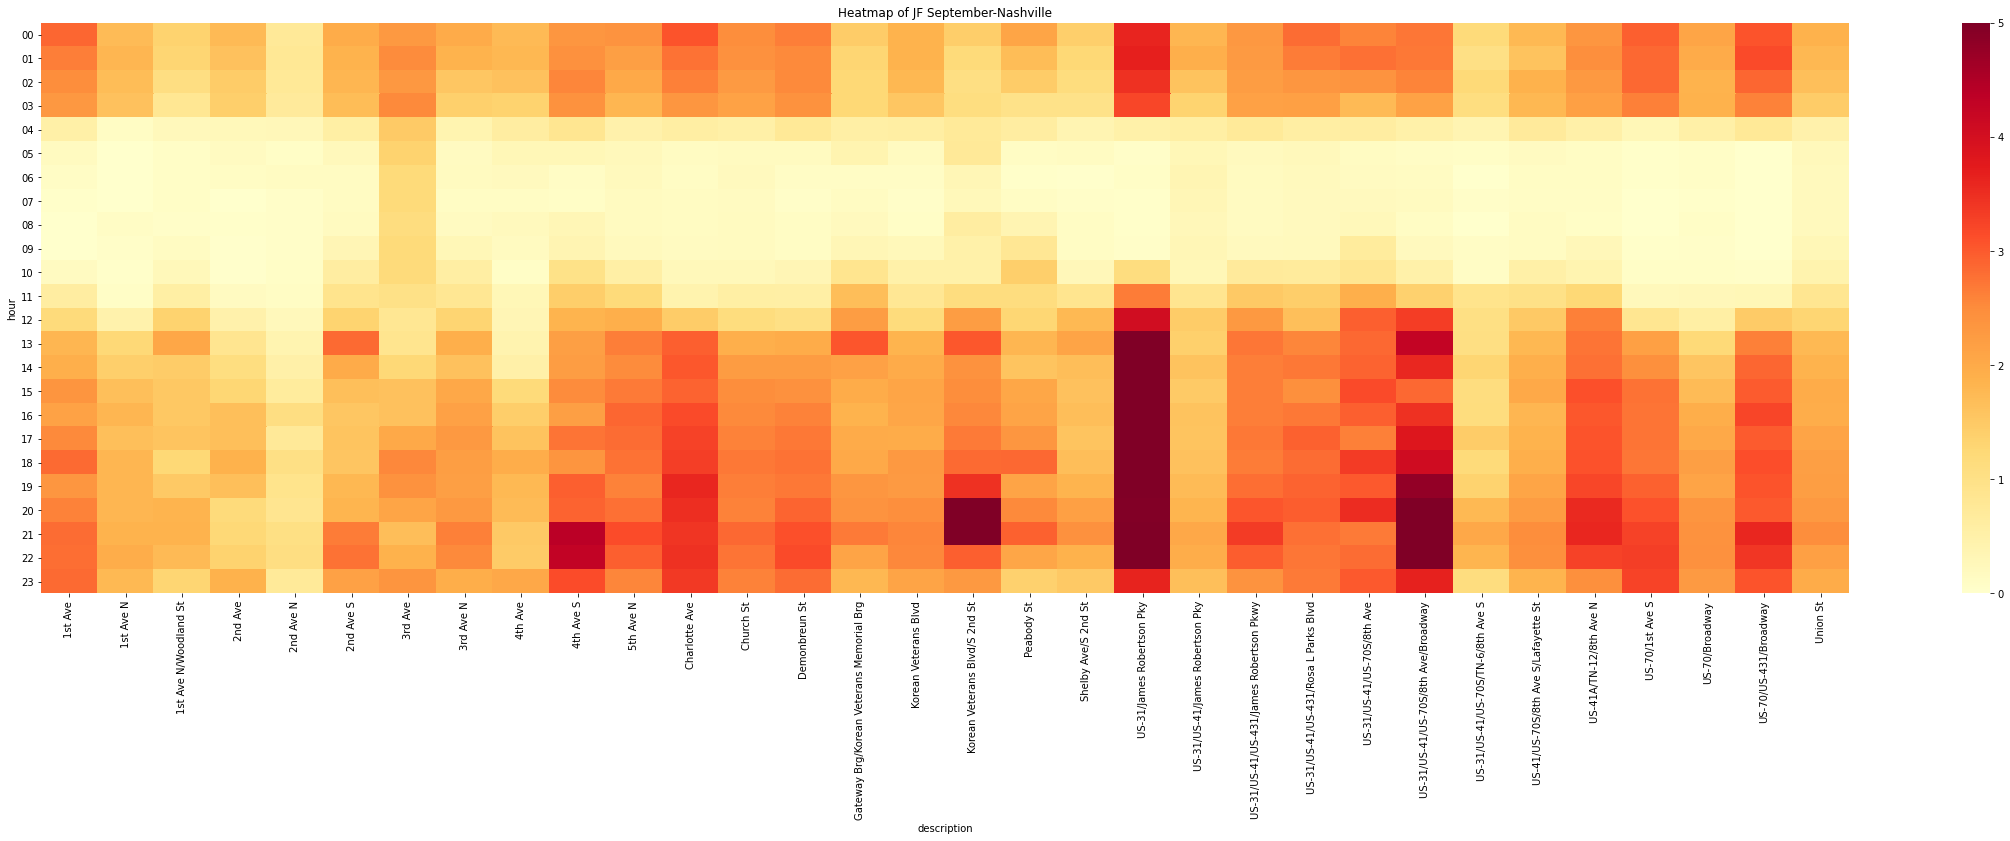

In [189]:
plot_spdf_hour_heatmap(spdf,'JF',"September-Nashville")

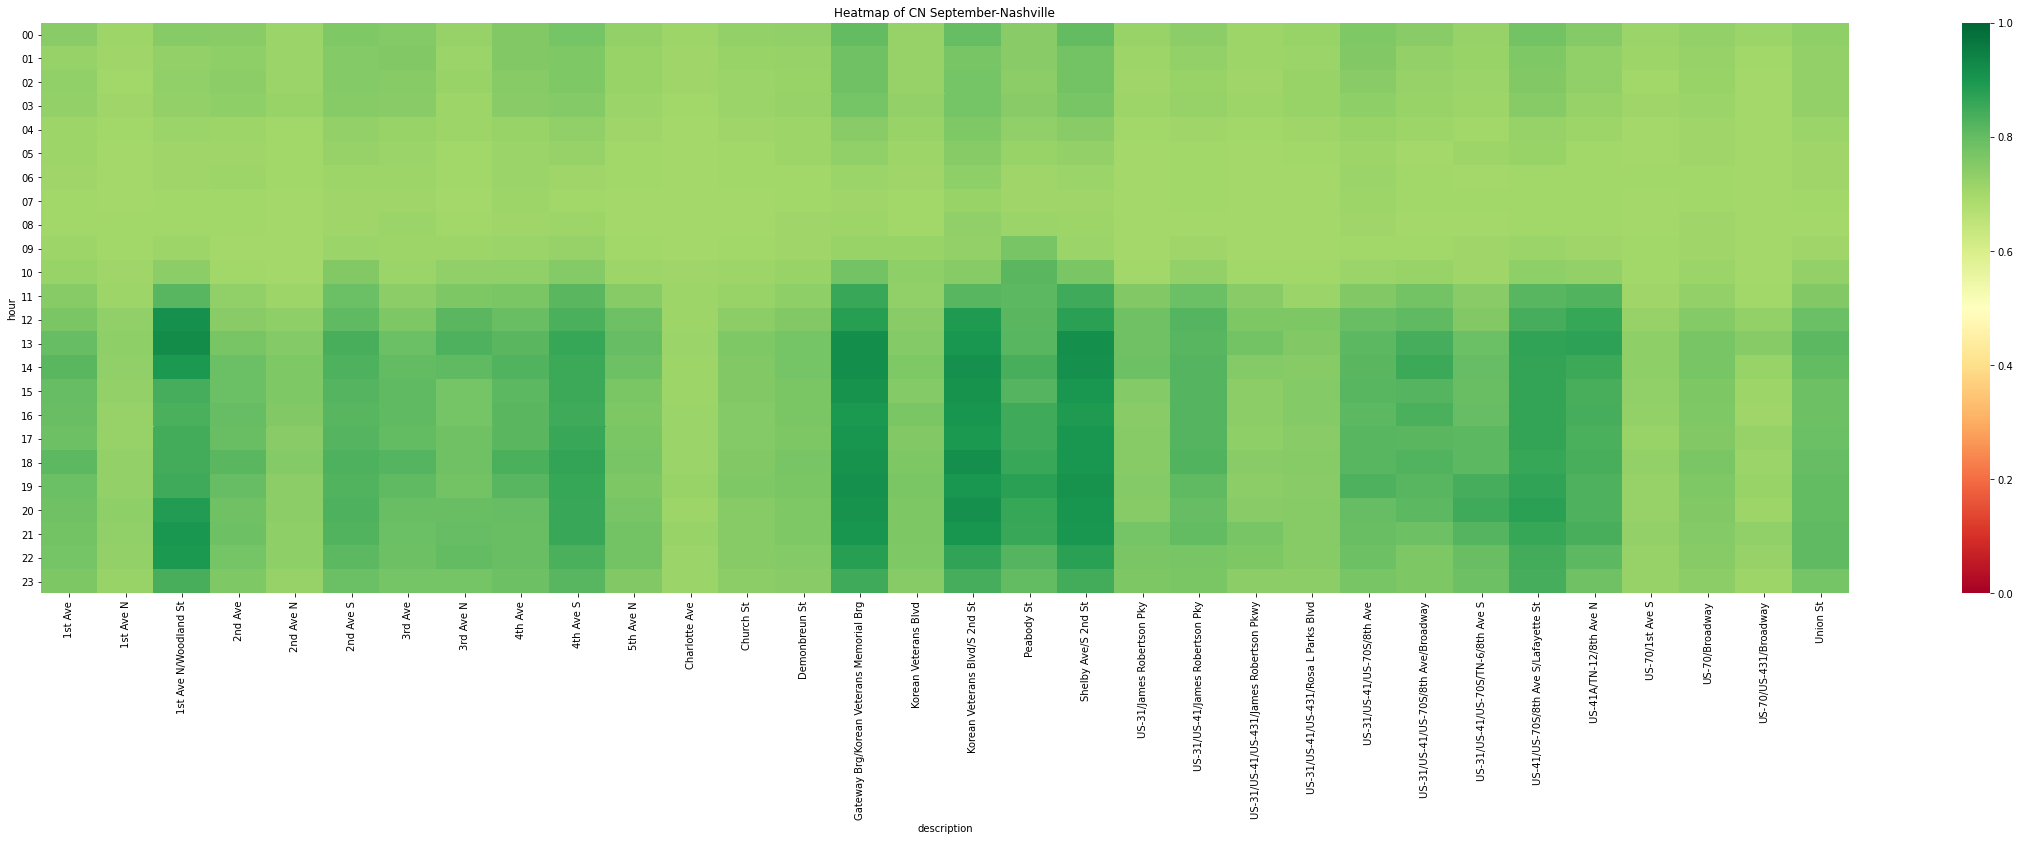

In [190]:
plot_spdf_hour_heatmap(spdf,'CN',"September-Nashville")

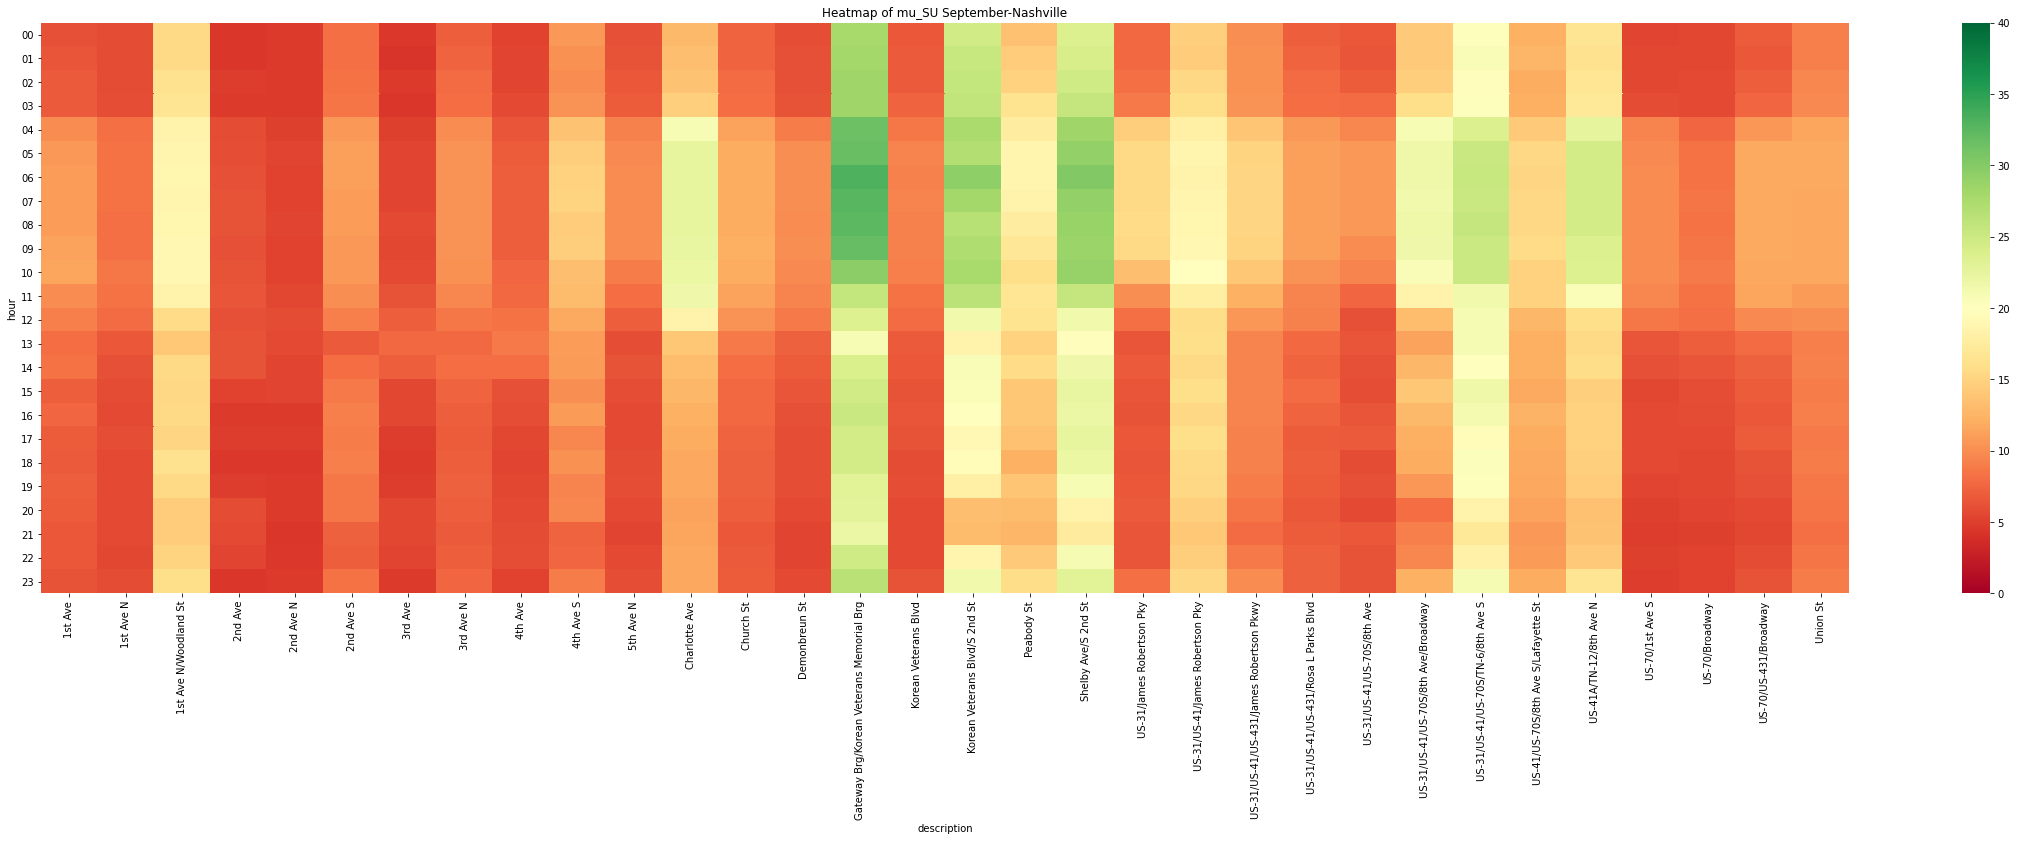

In [191]:
plot_spdf_hour_heatmap(spdf,'mu_SU',"September-Nashville")

##### Daily Averages

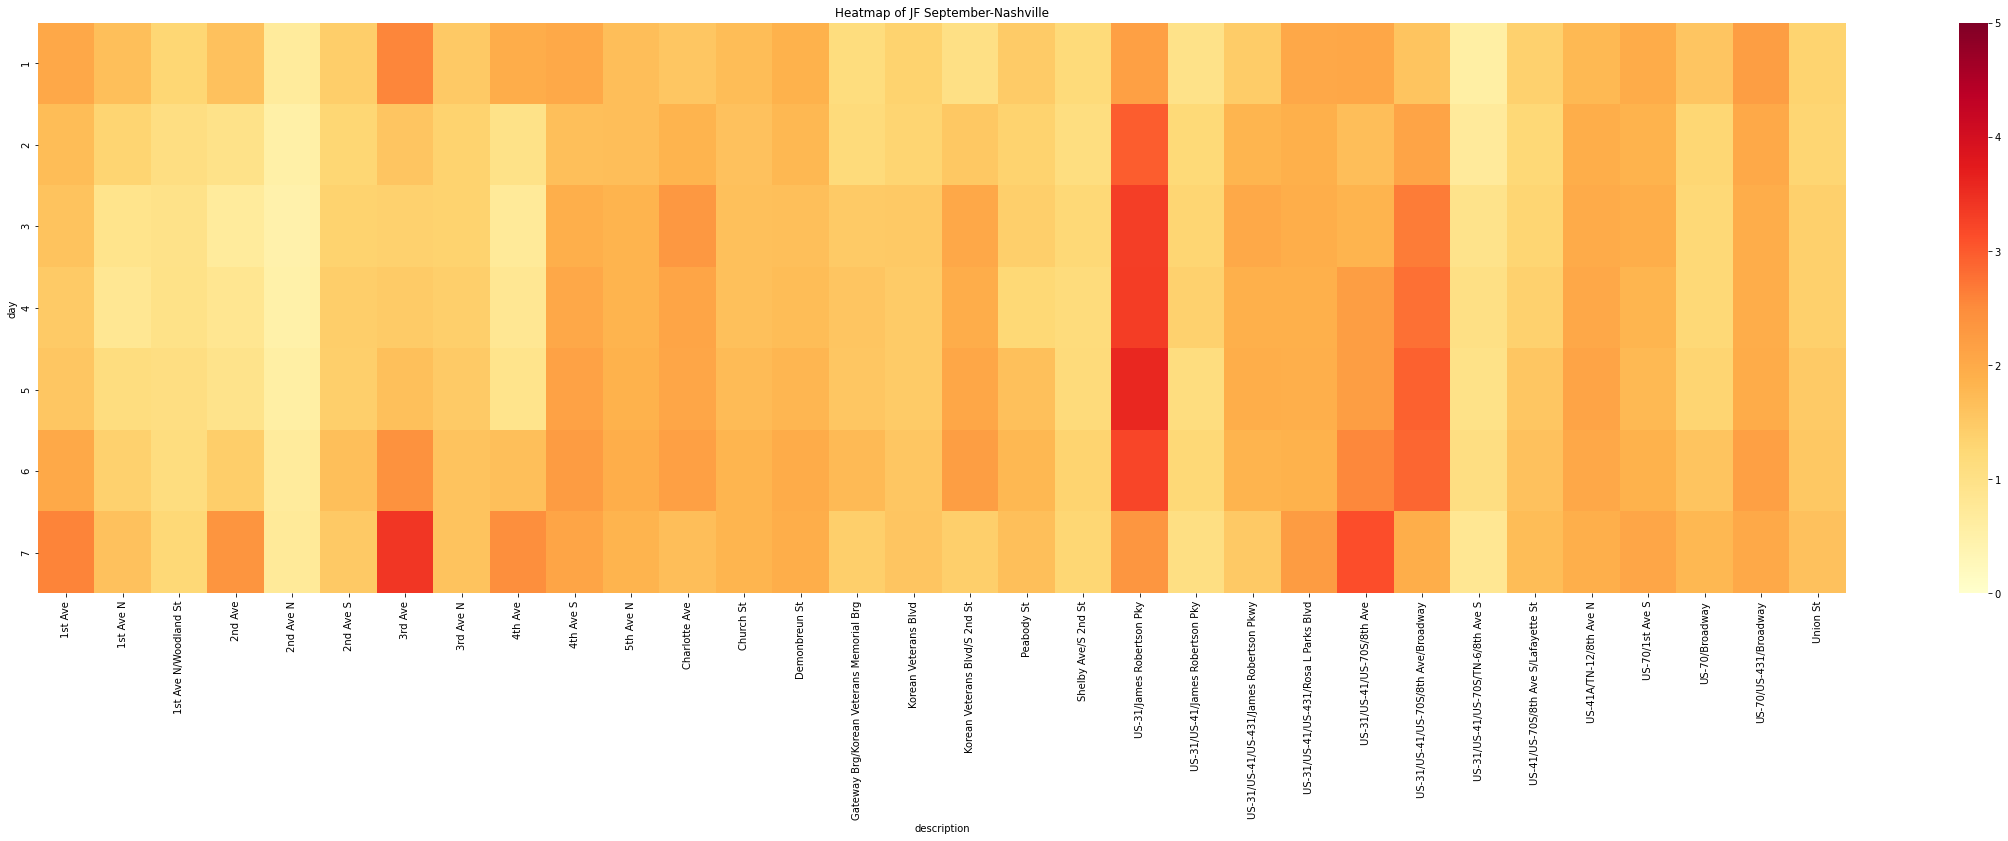

In [192]:
plot_spdf_day_heatmap(spdf,'JF',"September-Nashville")

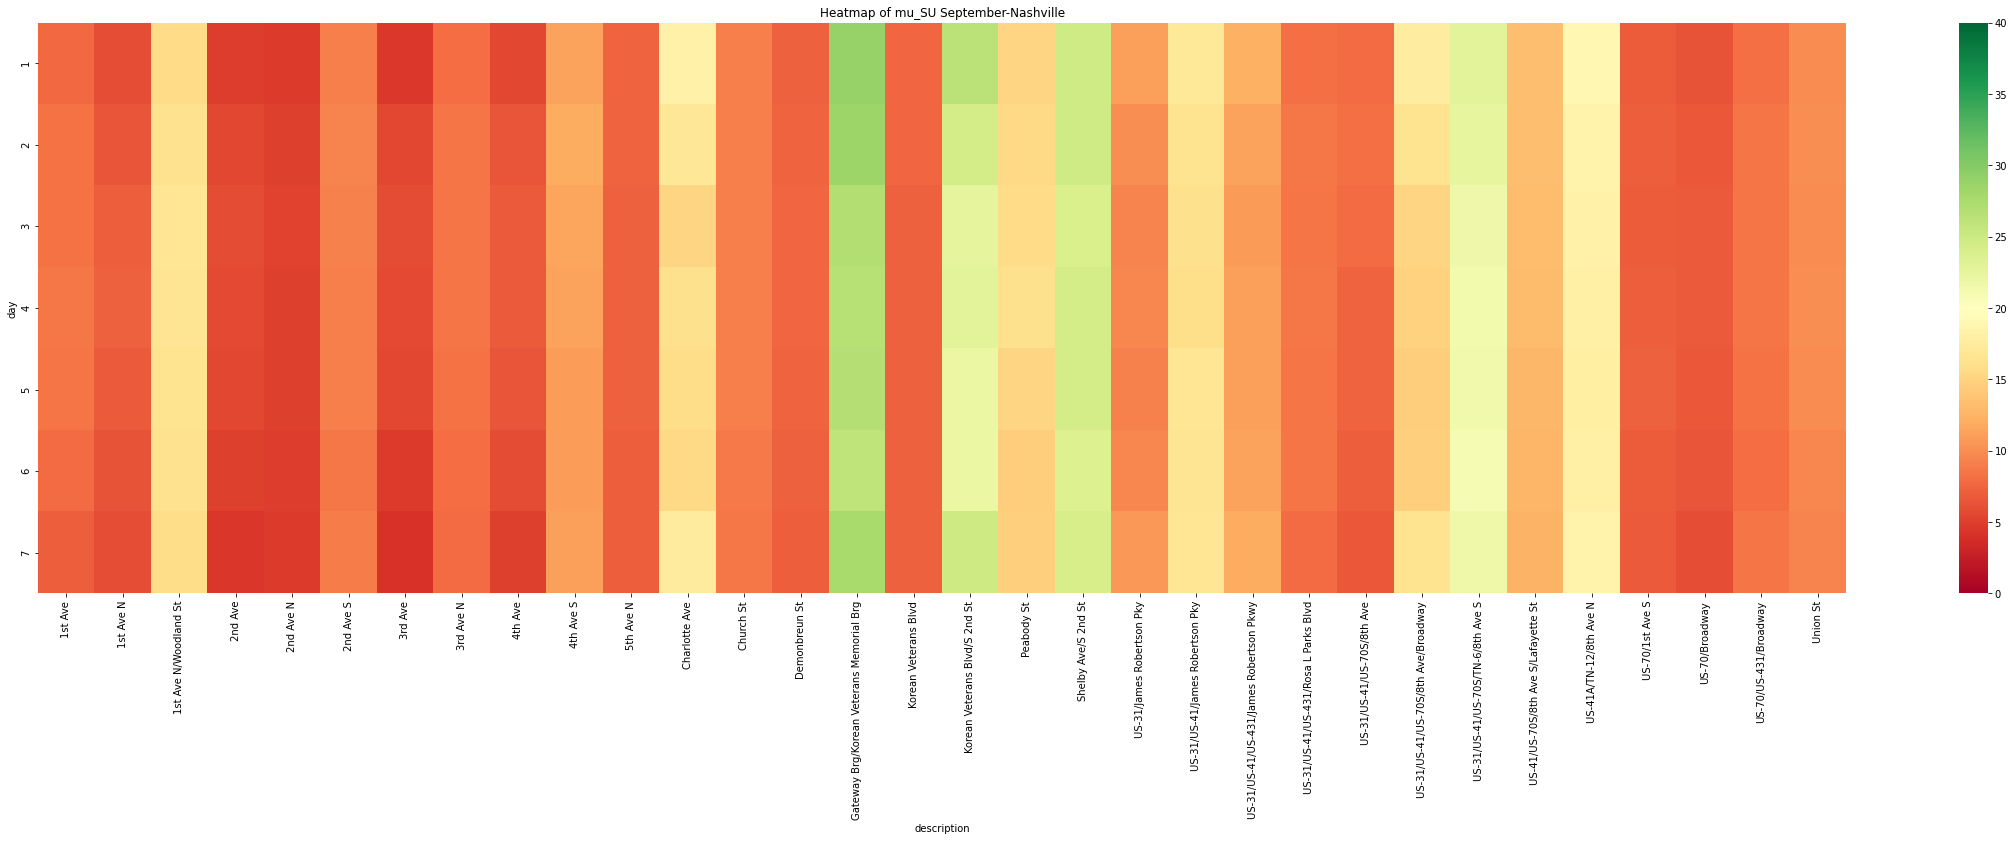

In [193]:
plot_spdf_day_heatmap(spdf,'mu_SU',"September-Nashville")

## Downtown Chattanooga

In [194]:
geojson_coordinate_list=[
          [
            [
              -85.2637767791748,
              35.071312088842106
            ],
            [
              -85.29836654663086,
              35.0167118782225
            ],
            [
              -85.27570724487303,
              35.01080696724293
            ],
            [
              -85.24558067321777,
              35.06702690594711
            ],
            [
              -85.2637767791748,
              35.071312088842106
            ]
          ]
        ]
query={
     "geom": {
       "$geoWithin": {
          "$geometry": {
             "type" : "Polygon" ,
             "coordinates": geojson_coordinate_list
          }
       }
     }
   }
selected_tmcs=db['here.chattanooga.shapes'].find(query)
selected_tmc_objects=[x for x in selected_tmcs]
selected_tmc_ids=[x['tmc_id'] for x in selected_tmc_objects]
len(selected_tmc_ids)

66

In [195]:
plot_tmc_ids(selected_tmc_objects)

### Month of April

In [ ]:
start_time1 = datetime.datetime(year=2020, month=4, day=1, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
end_time1 = datetime.datetime(year=2020, month=4, day=10, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
#let us say we want to aggregate averages by per hour
df,spdf=get_hourly_averages(start_time1,end_time1,'chattanooga')


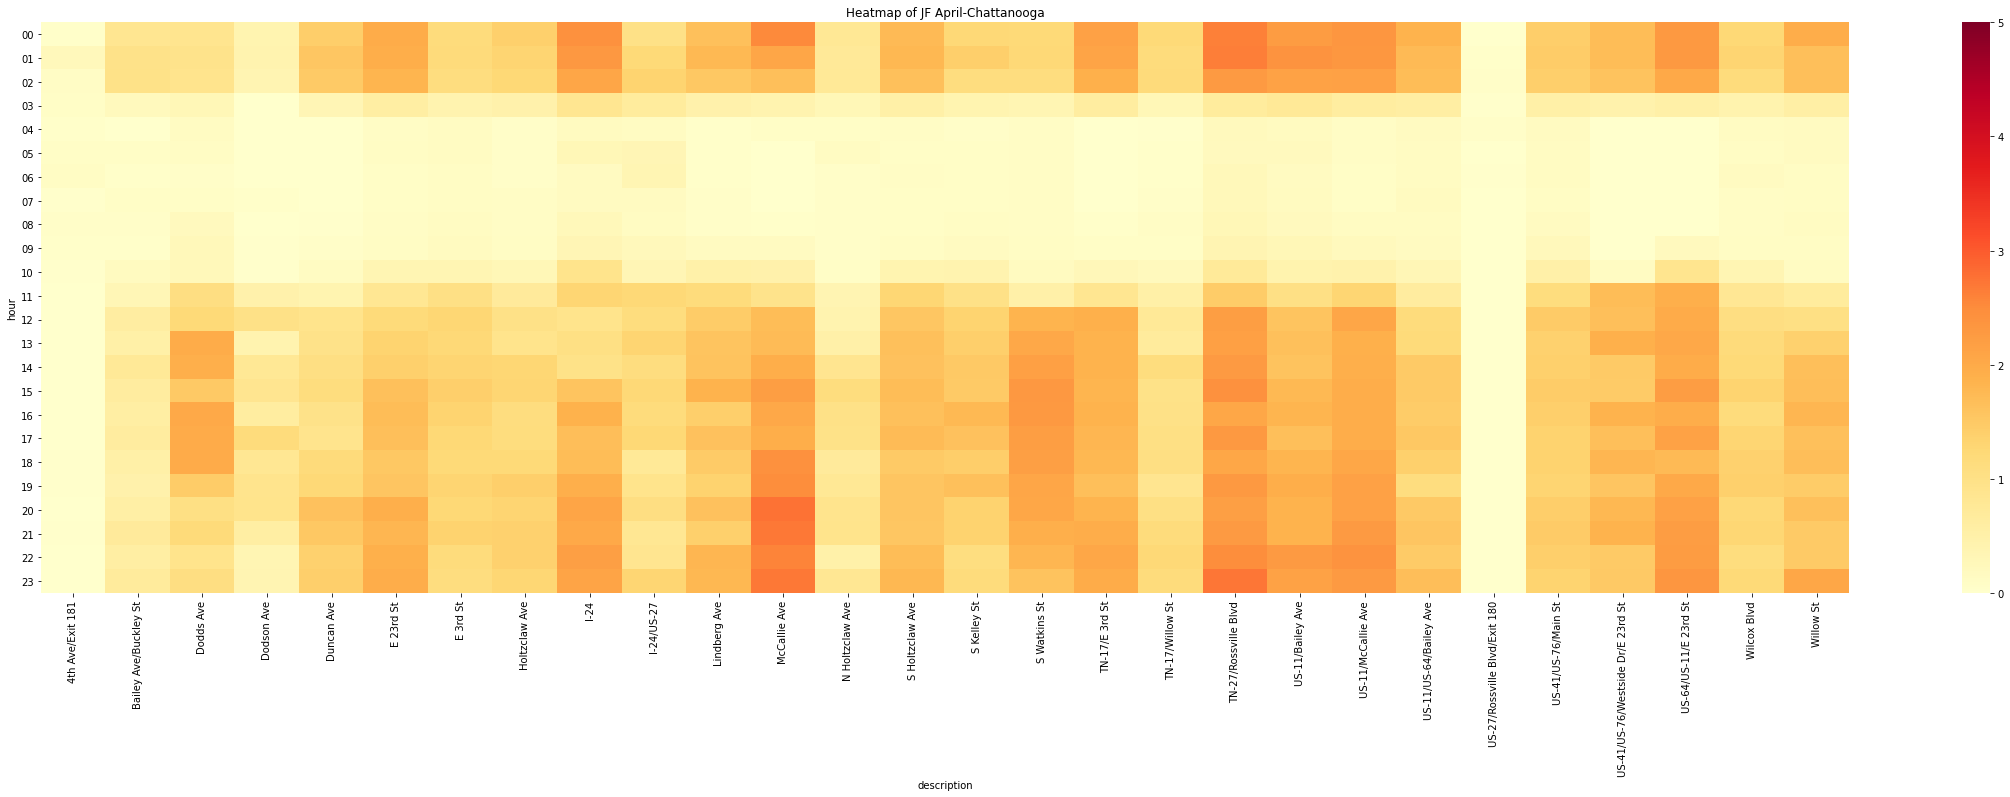

In [197]:
plot_spdf_hour_heatmap(spdf,'JF',"April-Chattanooga")

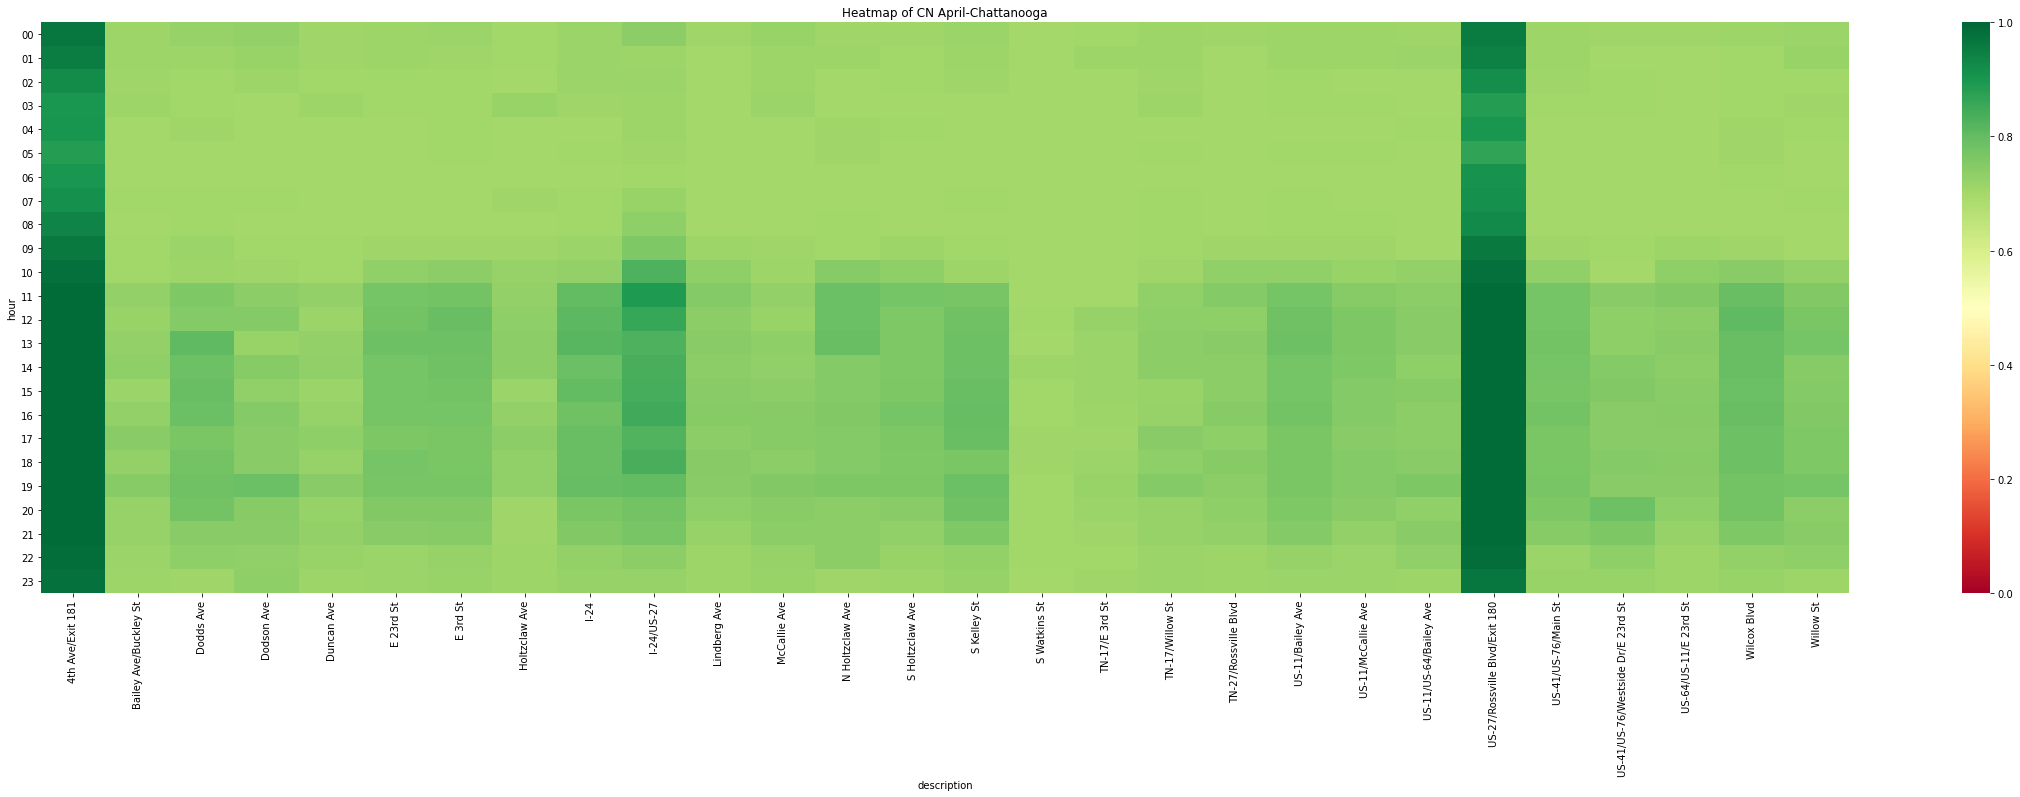

In [198]:
plot_spdf_hour_heatmap(spdf,'CN',"April-Chattanooga")


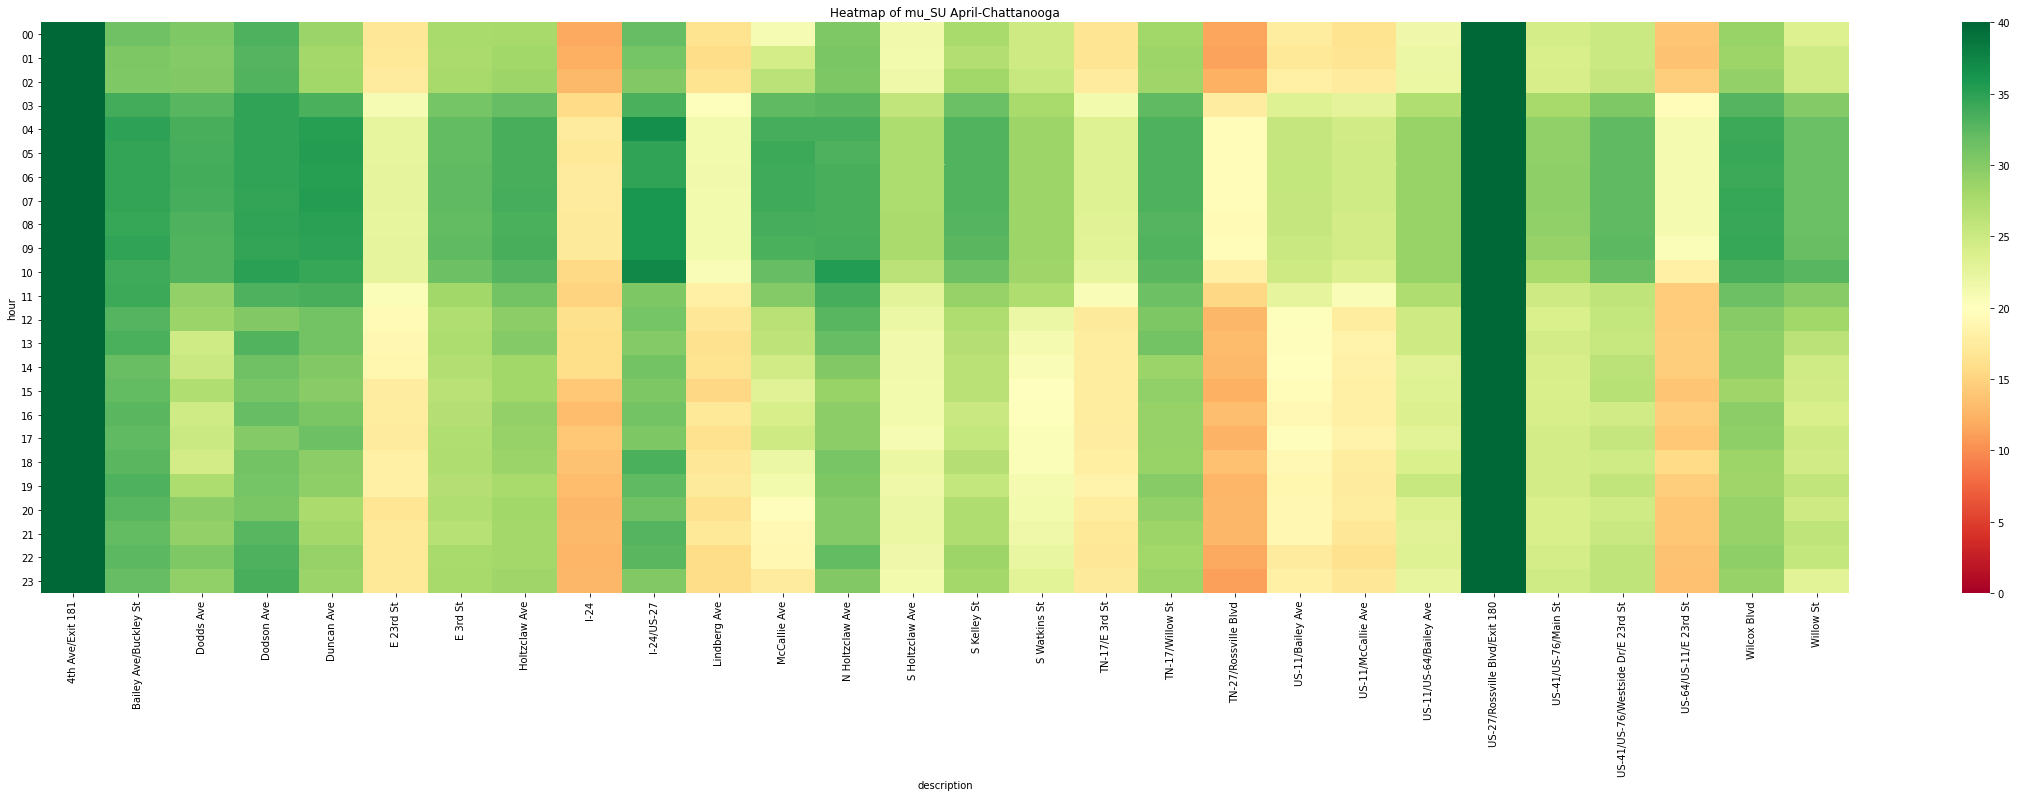

In [199]:
plot_spdf_hour_heatmap(spdf,'mu_SU',"April-Chattanooga")


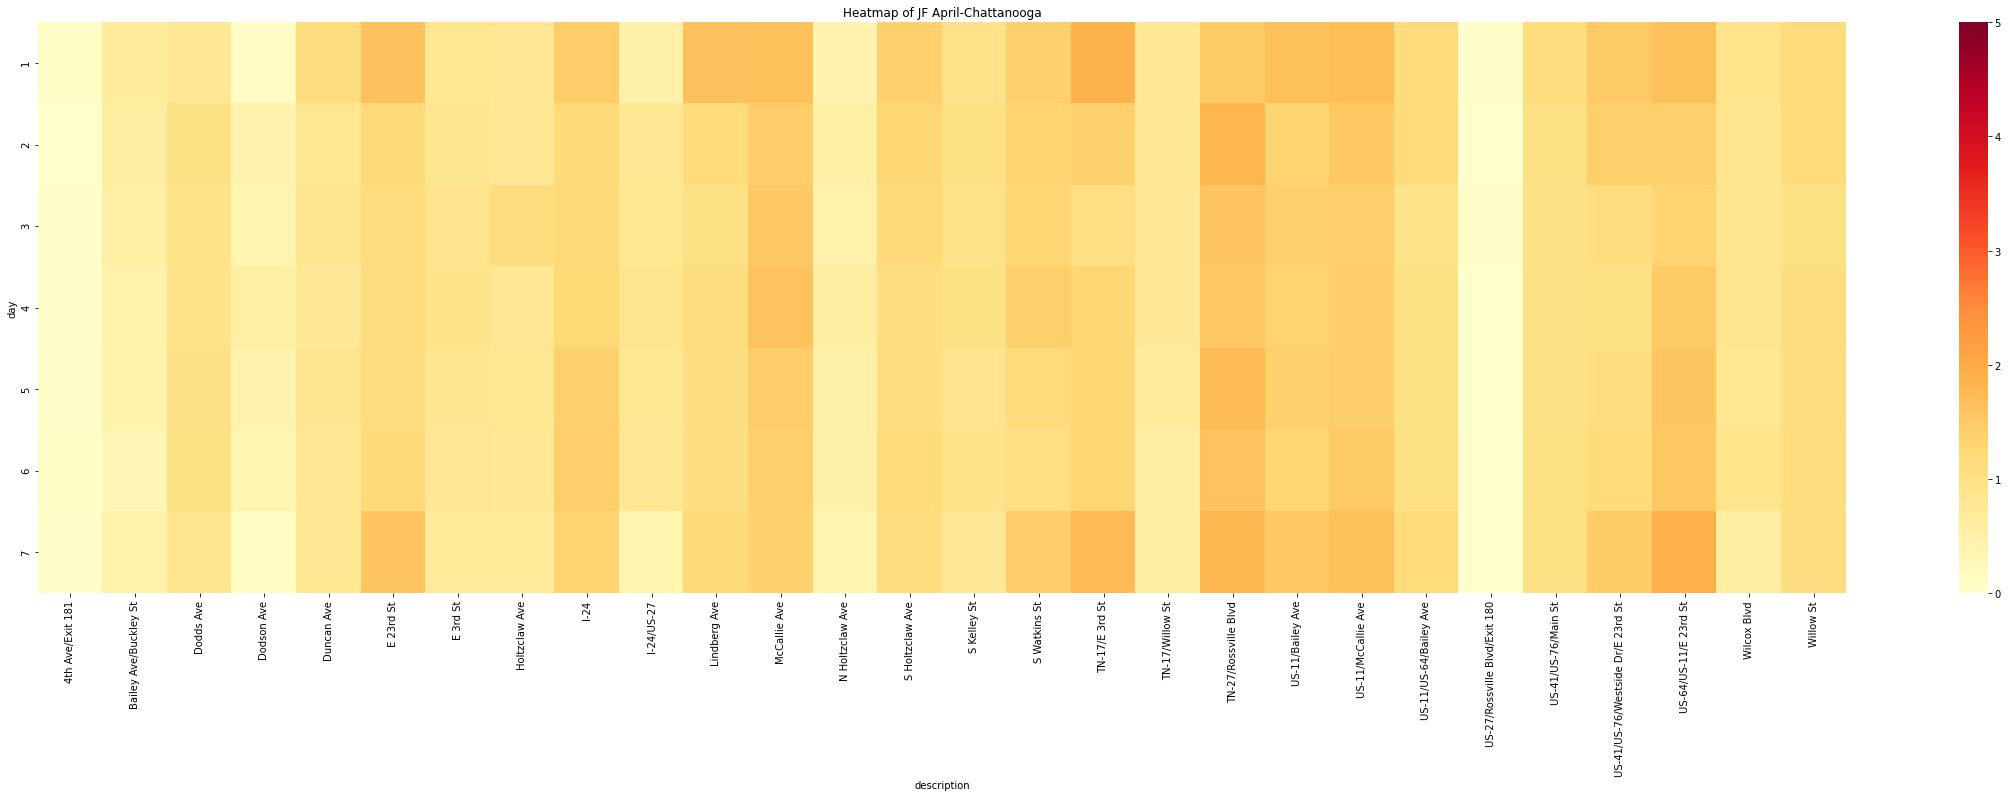

In [200]:
plot_spdf_day_heatmap(spdf,'JF',"April-Chattanooga")


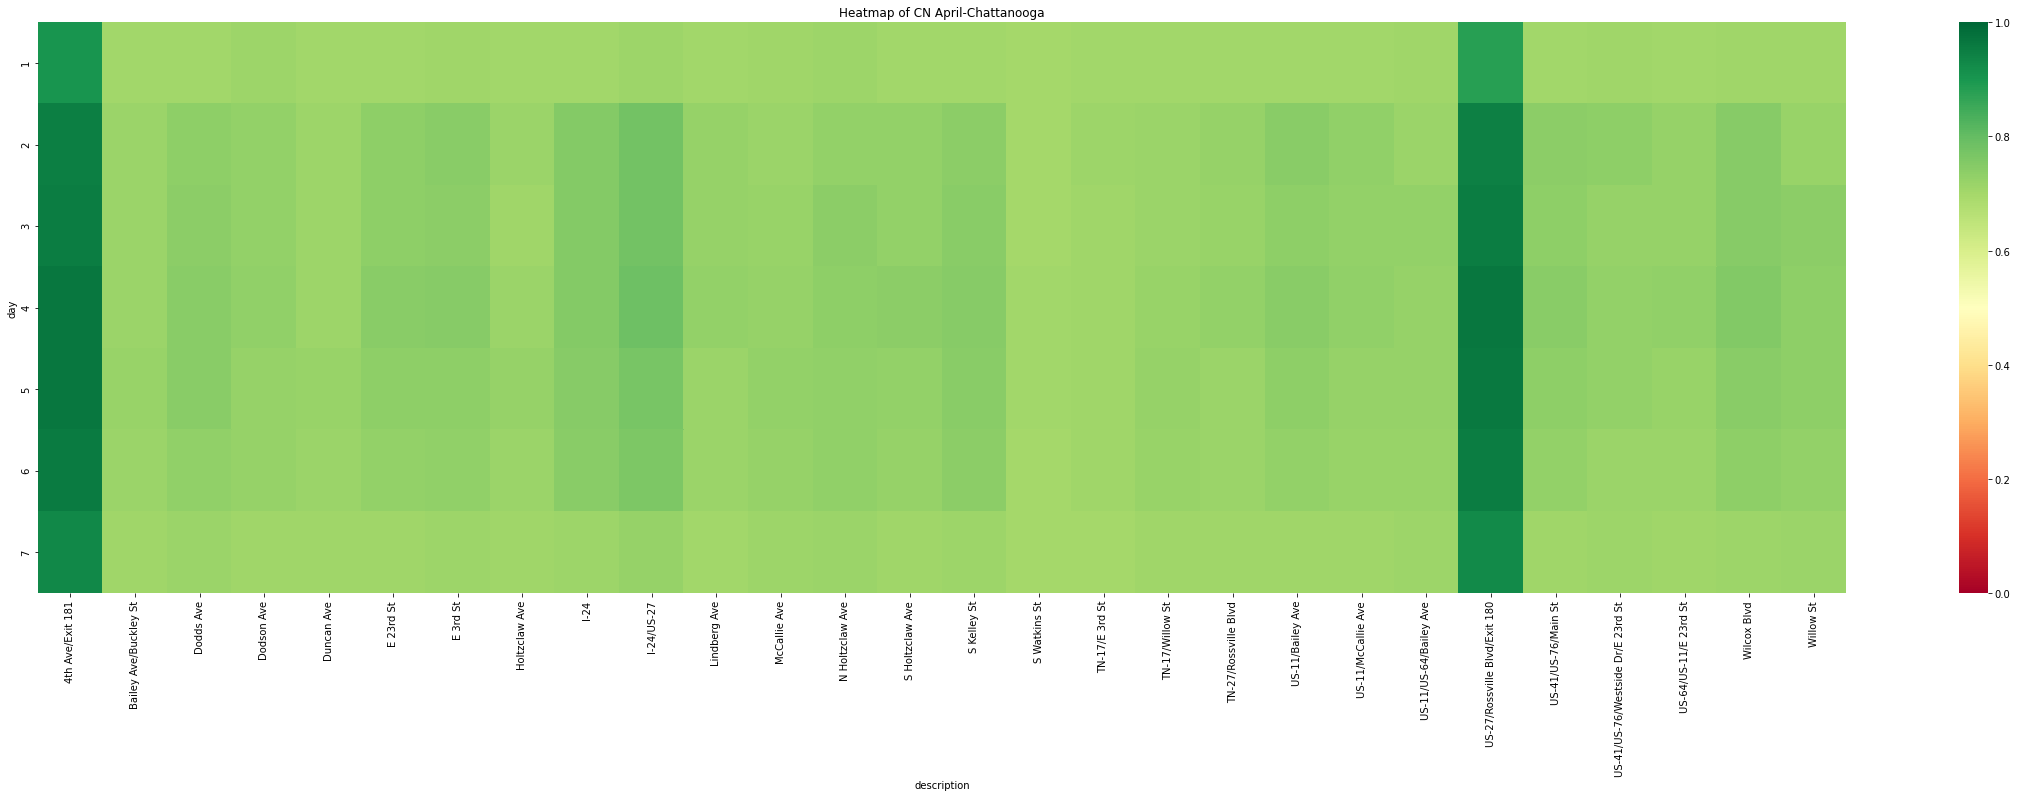

In [201]:
plot_spdf_day_heatmap(spdf,'CN',"April-Chattanooga")


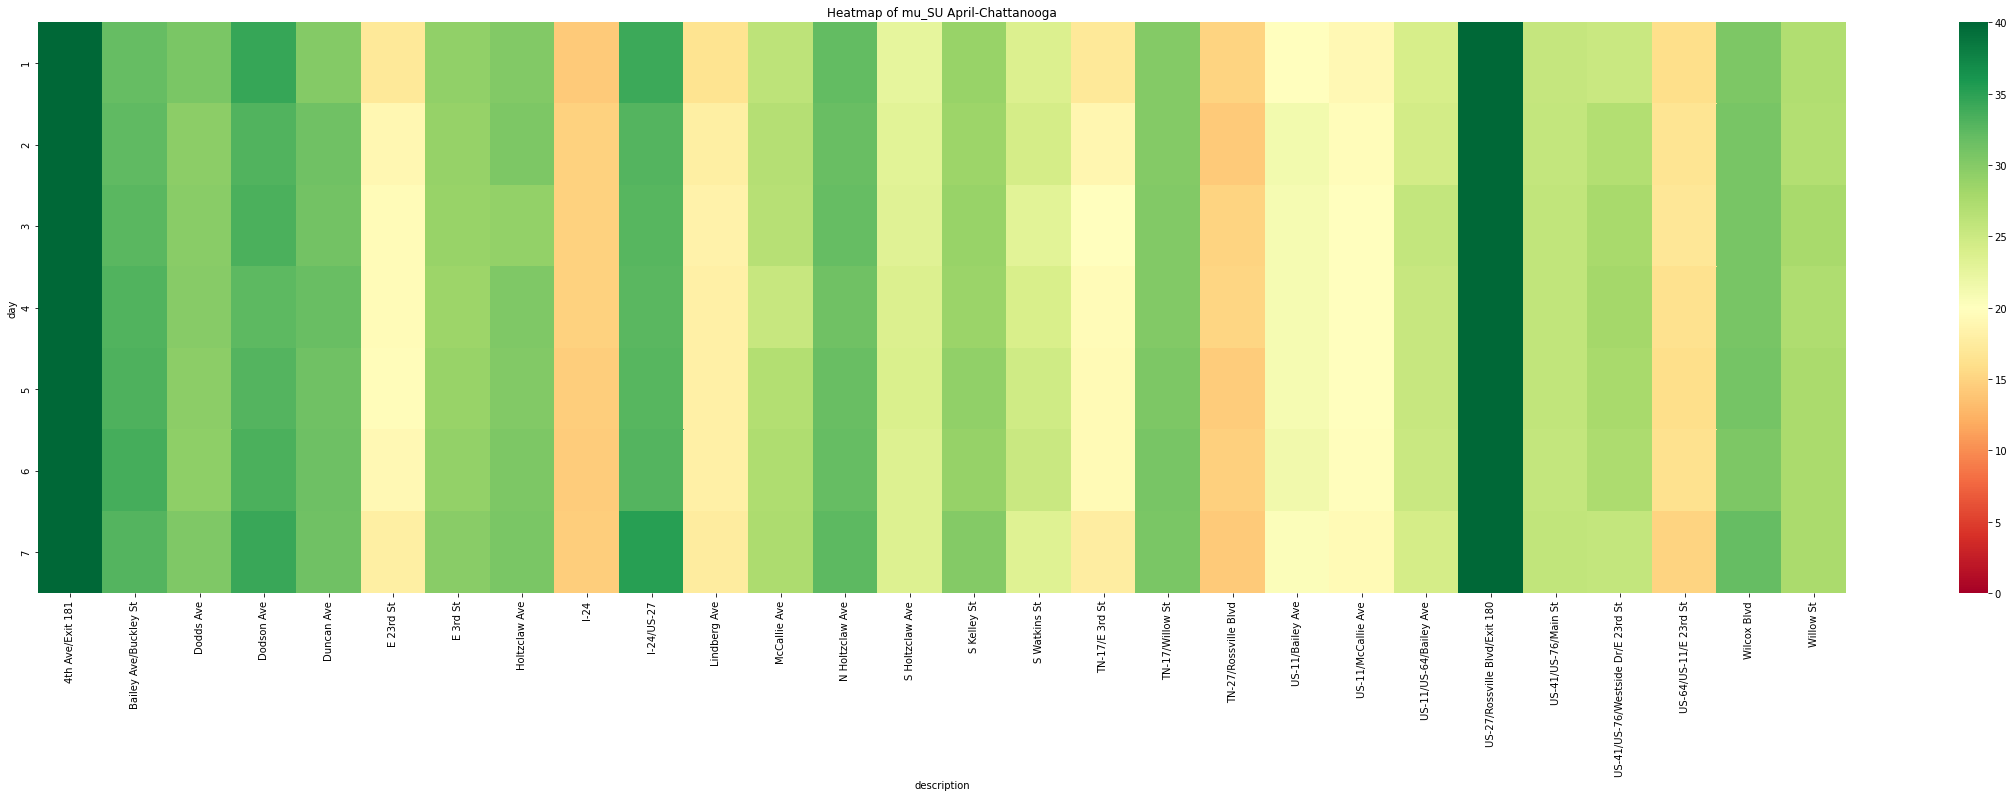

In [202]:
plot_spdf_day_heatmap(spdf,'mu_SU',"April-Chattanooga")

### Month of September

In [ ]:
start_time = datetime.datetime(year=2019, month=9, day=1, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
end_time = datetime.datetime(year=2019, month=9, day=30, hour=0, minute=0, second=0, tzinfo=datetime.timezone(-datetime.timedelta(hours=5)))
result,spdf=get_hourly_averages(start_time,end_time,'chattanooga')


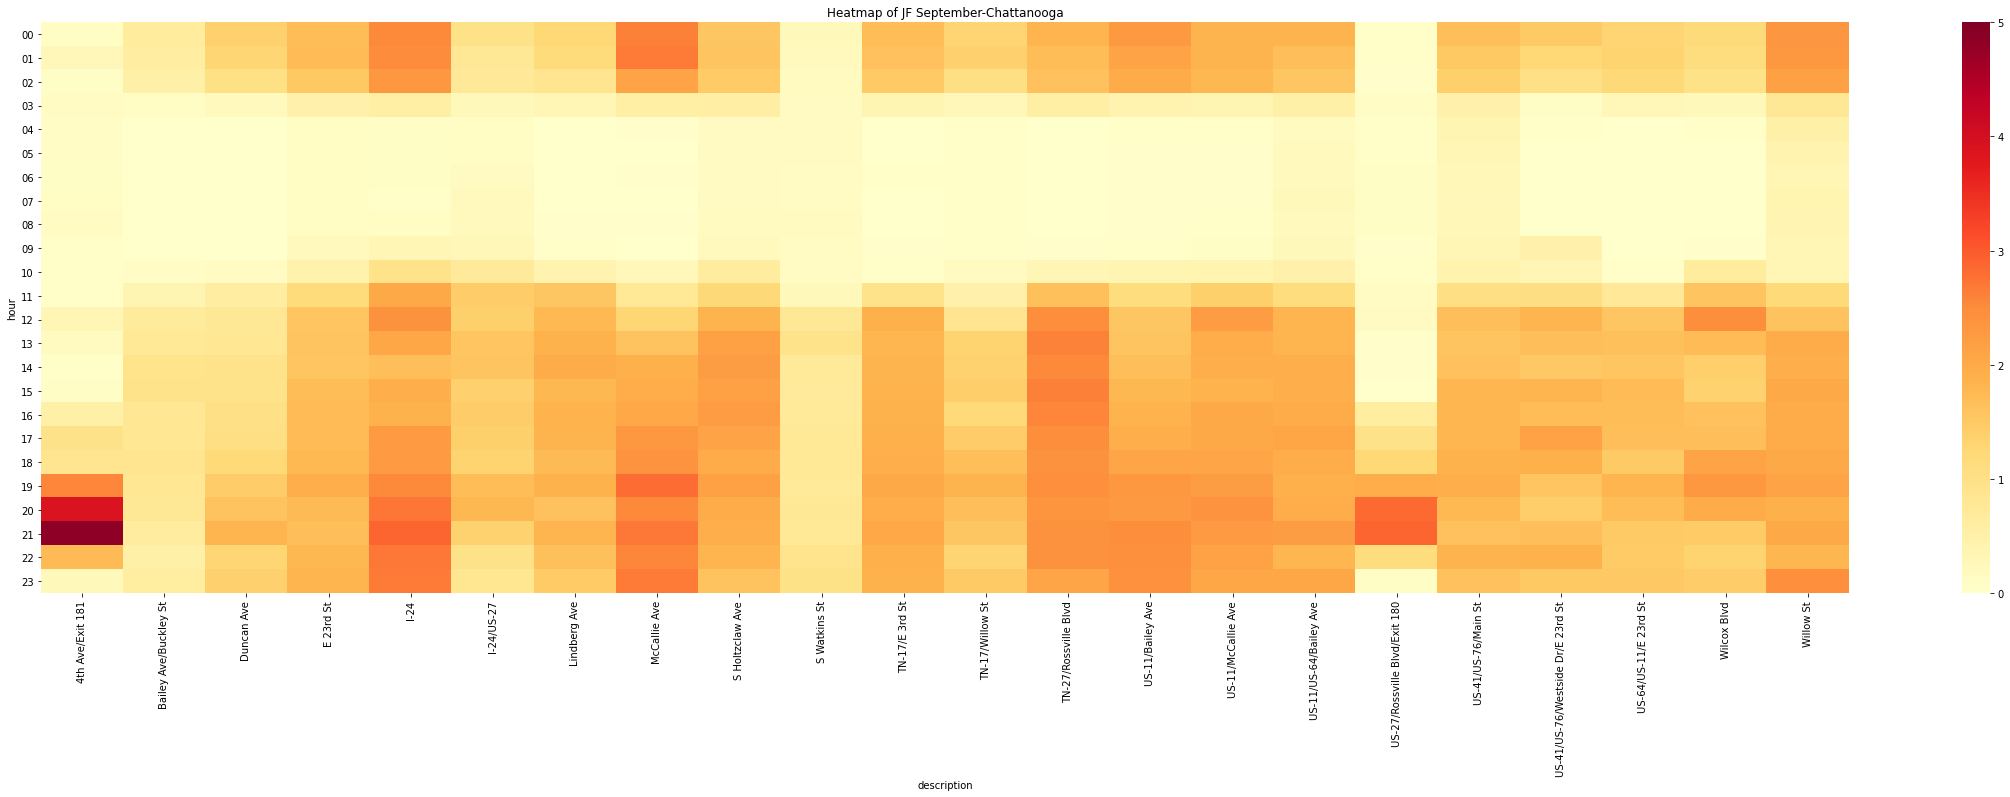

In [204]:
plot_spdf_hour_heatmap(spdf,'JF',"September-Chattanooga")


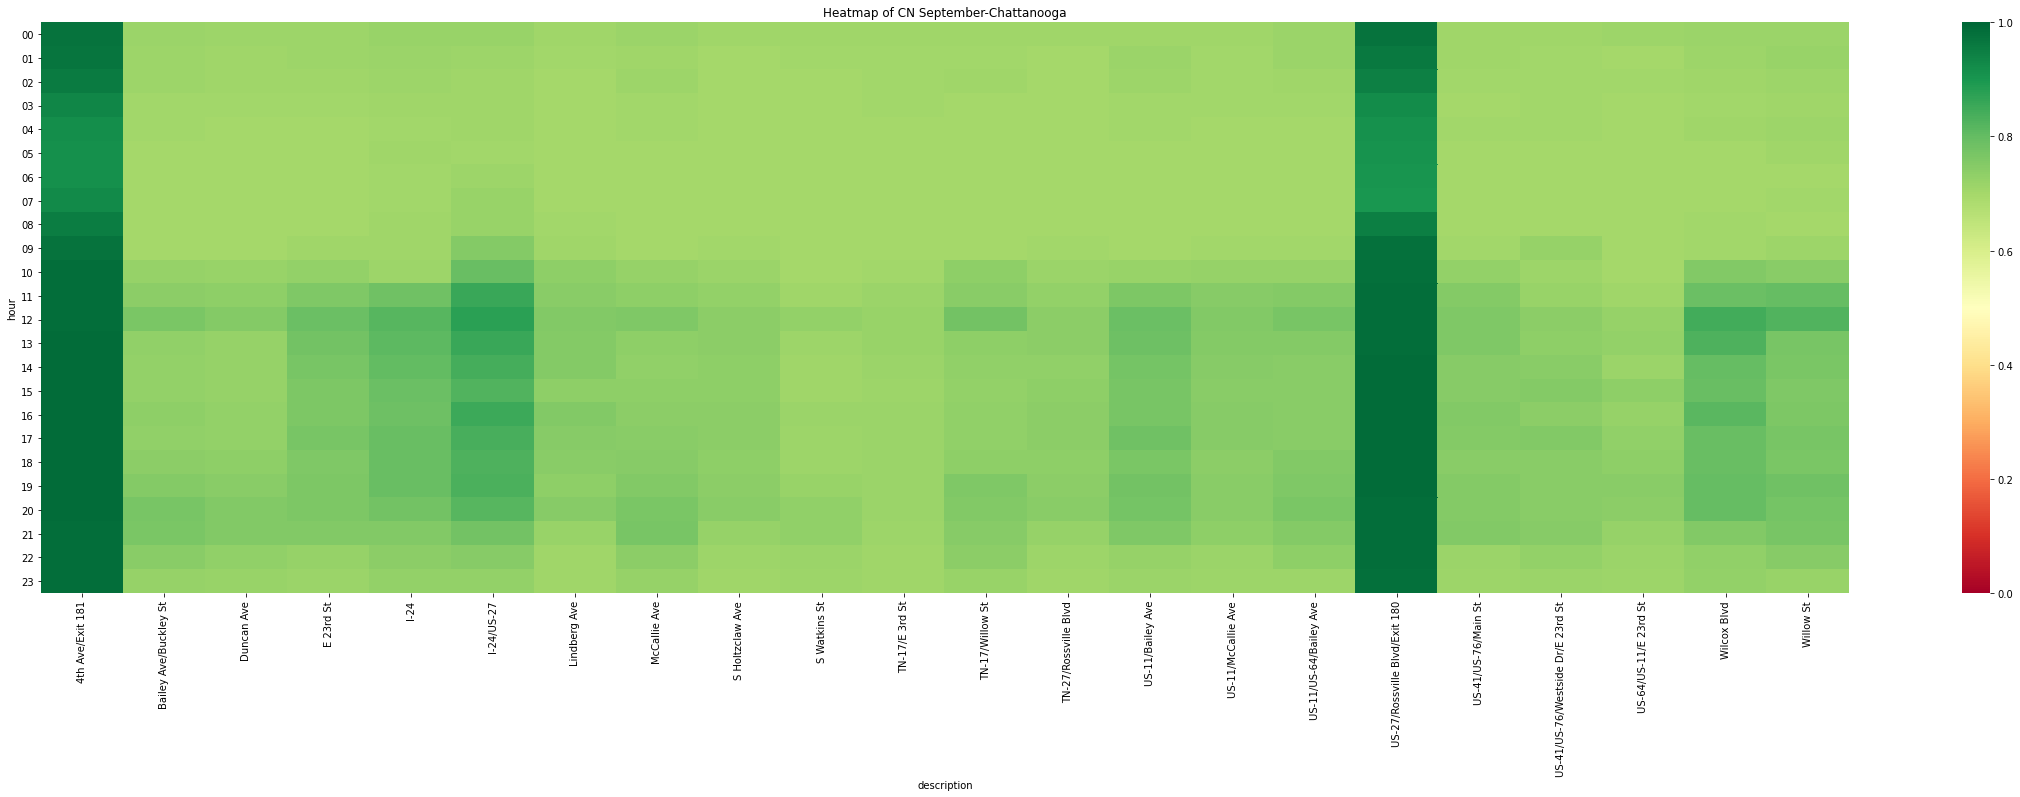

In [205]:
plot_spdf_hour_heatmap(spdf,'CN',"September-Chattanooga")


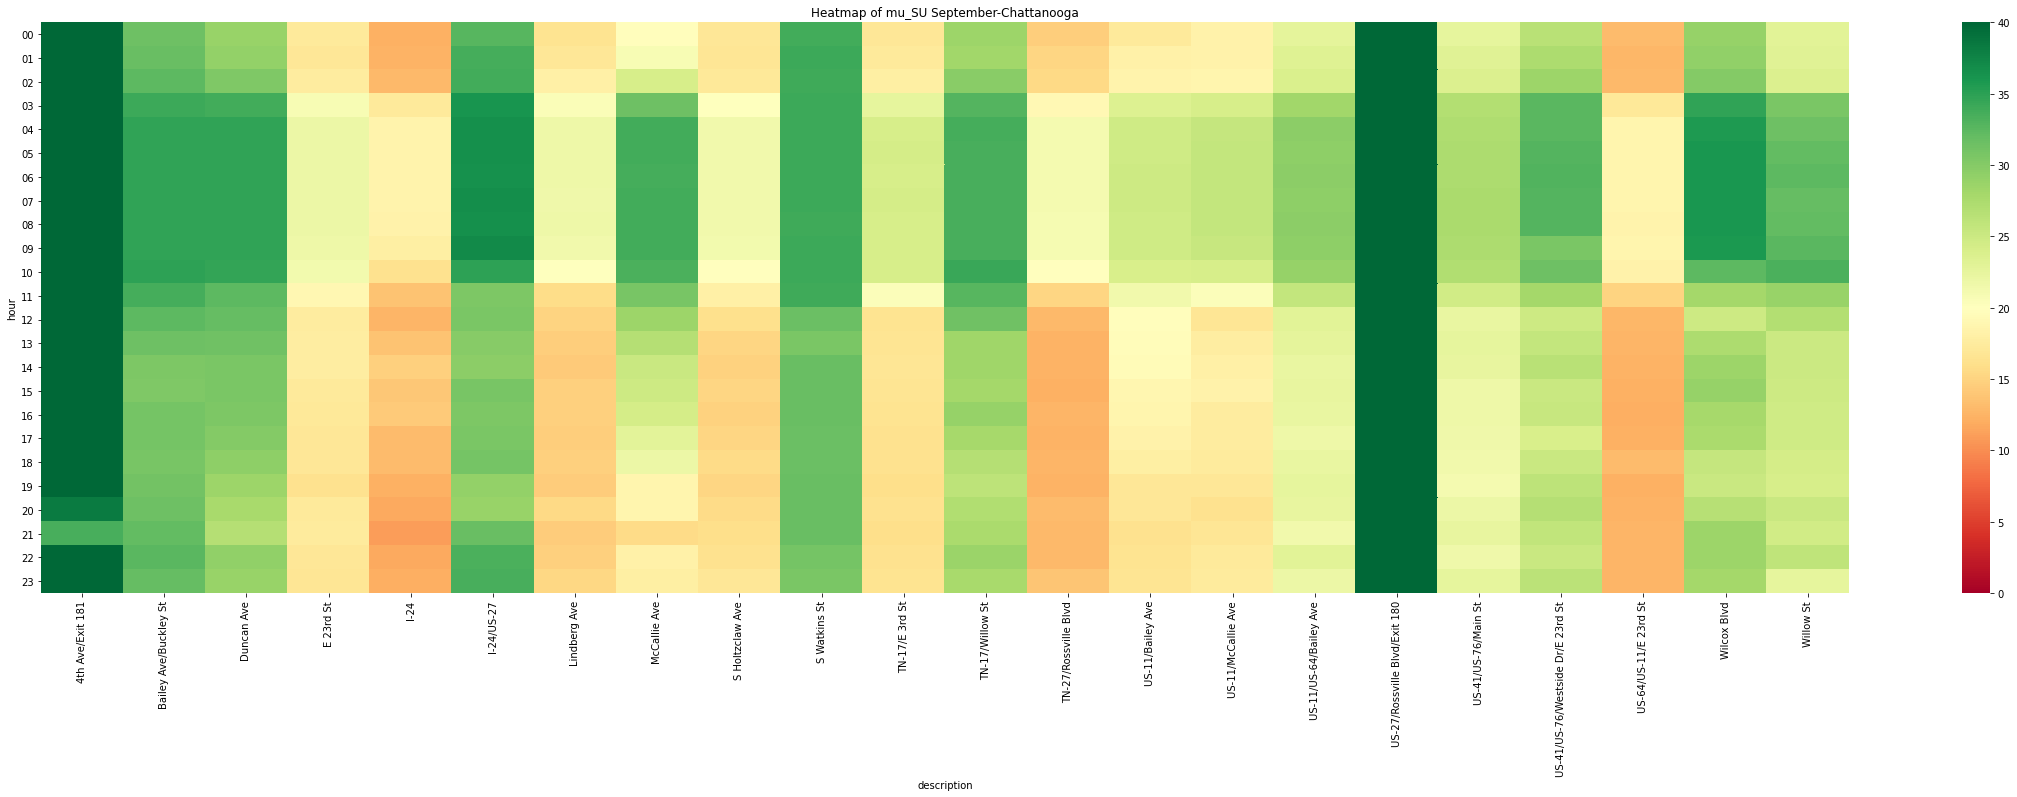

In [206]:
plot_spdf_hour_heatmap(spdf,'mu_SU',"September-Chattanooga")


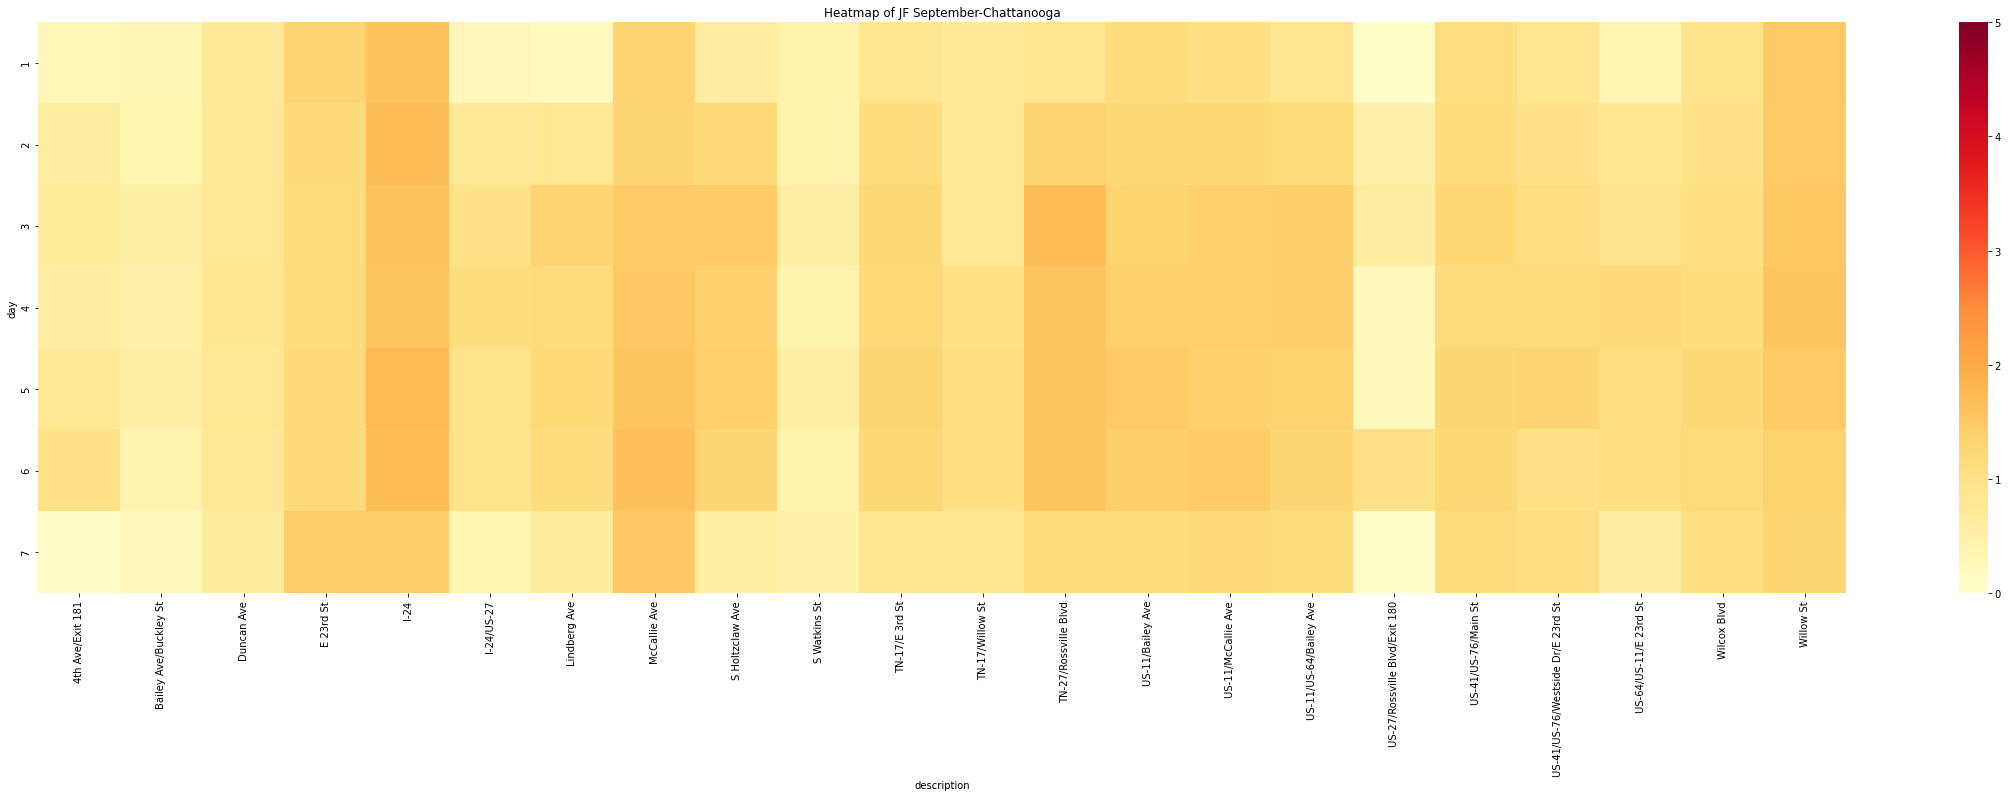

In [207]:
plot_spdf_day_heatmap(spdf,'JF',"September-Chattanooga")


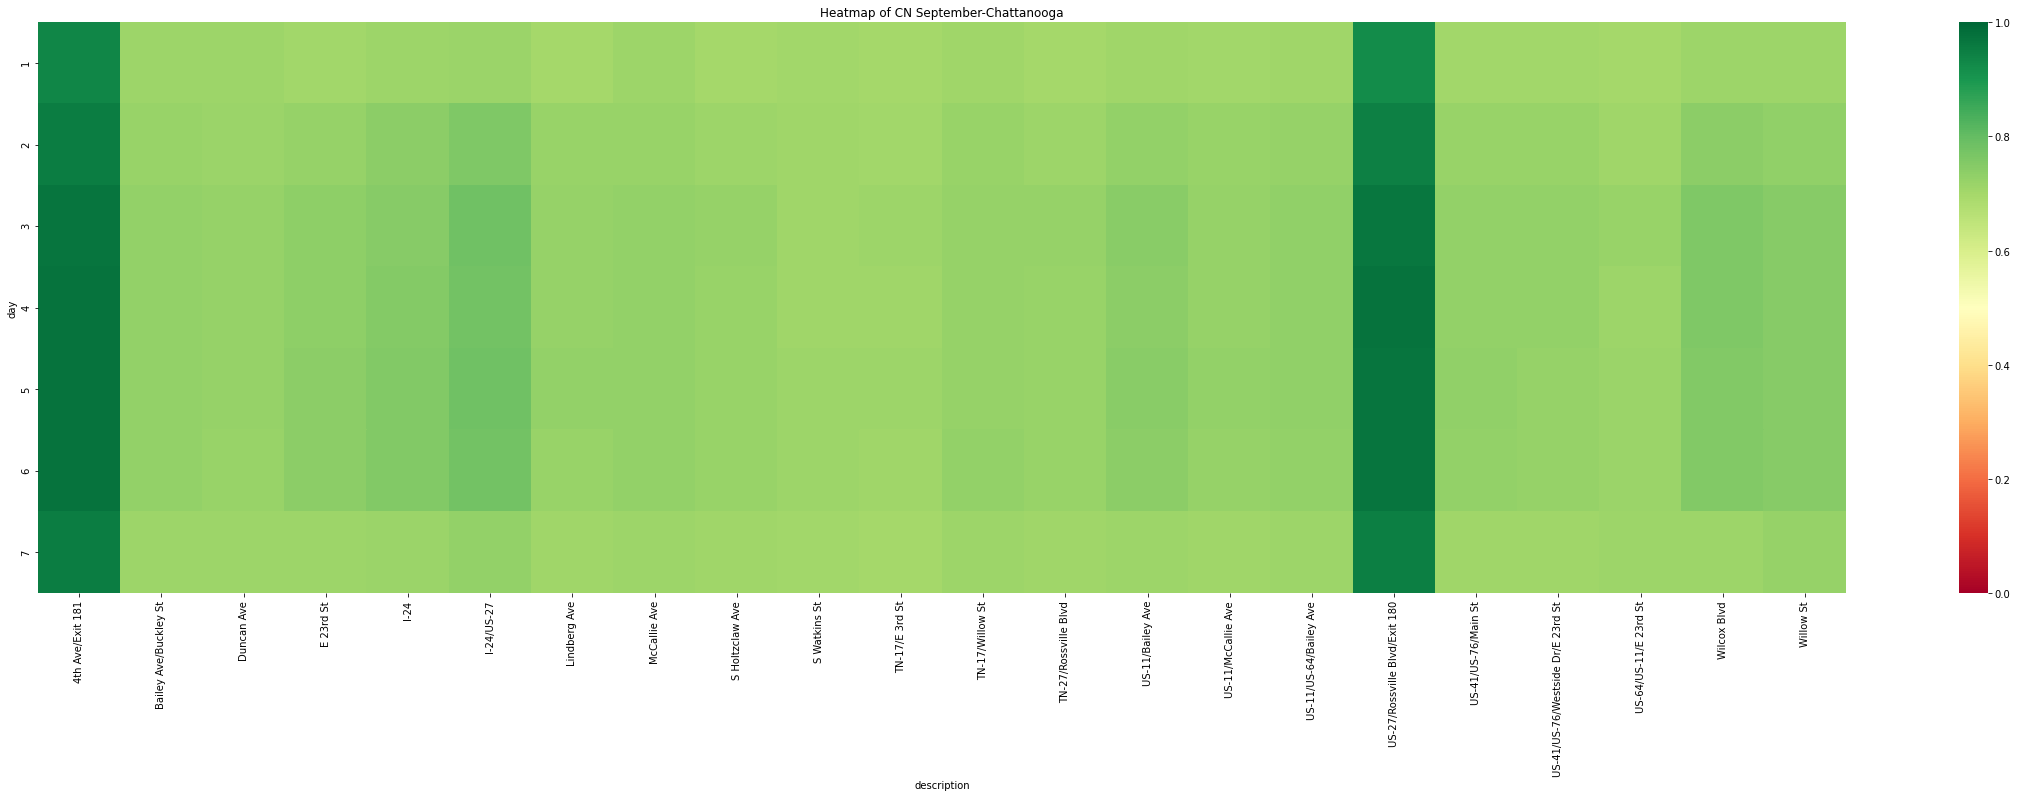

In [208]:
plot_spdf_day_heatmap(spdf,'CN',"September-Chattanooga")


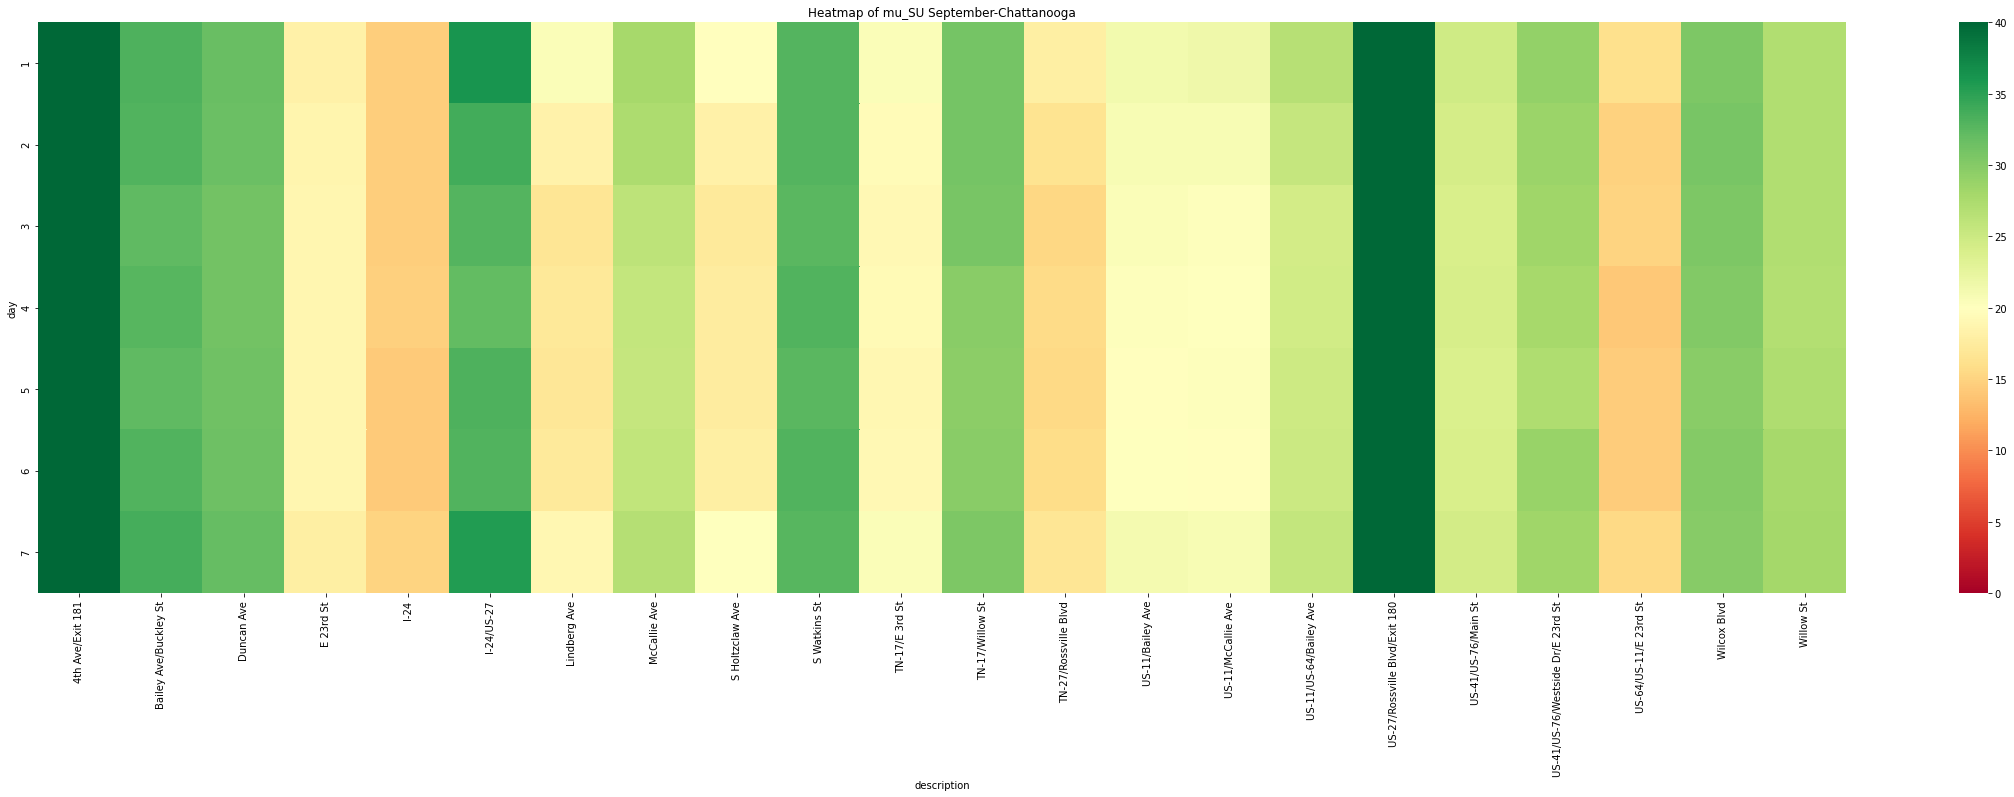

In [209]:
plot_spdf_day_heatmap(spdf,'mu_SU',"September-Chattanooga")